<a href="https://www.kaggle.com/code/mziaafzal/reconstruction-of-surfaces-numba-cpu-plus-gpu?scriptVersionId=277091130" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Numba based code for rectonstruction of 3D objects

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numba import cuda, njit, prange
import math, random, torch, copy, time
import matplotlib.pyplot as plt
from functools import wraps
from typing import List, Tuple, Optional
import functools
import gc

# GPU availability check
USE_GPU = cuda.is_available()
print("✅ GPU Available:", USE_GPU)

# The wraper function "timeit" can be used to measure the time of any function
def timeit(label=None):
    """Decorator to measure and print execution time of functions."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            name = label or func.__name__
            print(f"[{name}] {end - start:.4f} s")
            return result
        return wrapper
    return decorator

✅ GPU Available: True


### Functions to obtain contour at each height using TNT Goodman "Shape perserving interpolation by parametric rational cubic splines"

In [2]:
# --- Helper functions (all float32-safe) ---
@njit(fastmath=True)
def cross2d_float(a, b):
    # a, b are length-2 arrays (float32)
    return a[0]*b[1] - a[1]*b[0]

@njit(fastmath=True)
def vec_norm_float(a):
    # Euclidean norm for a length-2 float32 vector
    return np.sqrt(a[0]*a[0] + a[1]*a[1])

@njit(fastmath=True)
def safe_div_float(num, den, dtype=None):
    # safe division returning float32, handle den == 0
    if den == 0.0:
        if dtype is None:
            return np.float64(0.0)
        else:
            return dtype(0.0)
    else:
        return num / den

# --- Rewritten curve function (float32-safe) ---
# ---------------------
# float32 specialized function
# ---------------------
@njit(parallel=True, fastmath=True)
def curve_goodman_numba_f32(I, seg_pts):
    """
    Goodman-style closed curve smoothing — float32-safe Numba implementation.

    Parameters
    ----------
    I : (no_pts, 2) ndarray (float32)
        Closed polygon points in order (I[0]..I[no_pts-1]), dtype must be np.float32.
    seg_pts : int
        Number of interpolation points per segment (end point excluded).

    Returns
    -------
    r : (no_pts * seg_pts, 2) ndarray (float32)
        Smoothed curve points in float32.
    """
    dtype = np.float32

    no_pts = I.shape[0]

    # constants as dtype
    m = dtype(0.5)
    n = dtype(0.5)
    r_coef = dtype(0.25)
    s_coef = dtype(0.25)
    zero = dtype(0.0)
    one = dtype(1.0)
    two = dtype(2.0)
    eps = dtype(1e-6)

    # build t values in float32 excluding the final endpoint
    t_vals = np.empty(seg_pts, dtype=dtype)
    for j in range(seg_pts):
        # j / seg_pts  in float32
        t_vals[j] = dtype(j) / dtype(seg_pts)

    # allocate arrays (all float32)
    lineleft = np.zeros(no_pts, dtype=np.bool_)
    lineright = np.zeros(no_pts, dtype=np.bool_)
    kleft = np.zeros(no_pts, dtype=dtype)
    kright = np.zeros(no_pts, dtype=dtype)

    # --- curvature flags + curvature values ---
    for i in prange(no_pts):
        im1 = (i - 1) % no_pts
        ip1 = (i + 1) % no_pts
        ip2 = (i + 2) % no_pts
        im2 = (i - 2) % no_pts

        # collinearity checks using cross products (float32)
        lhs1 = (I[i,1] - I[im1,1]) * (I[ip1,0] - I[im1,0]) - (I[ip1,1] - I[im1,1]) * (I[i,0] - I[im1,0])
        if abs(lhs1) < eps:  # tolerance in float32/float64
            lineleft[i] = True
            lineright[i] = True
        else:
            lhs2 = (I[i,1] - I[ip1,1]) * (I[ip2,0] - I[ip1,0]) - (I[ip2,1] - I[ip1,1]) * (I[i,0] - I[ip1,0])
            if abs(lhs2) < eps:
                lineright[i] = True
            else:
                lhs3 = (I[i,1] - I[im1,1]) * (I[im2,0] - I[im1,0]) - (I[im2,1] - I[im1,1]) * (I[i,0] - I[im1,0])
                if abs(lhs3) < eps:
                    lineleft[i] = True

        if not lineleft[i]:
            # compute curvature-like quantity (float32-safe)
            v1 = np.empty(2, dtype=dtype); v2 = np.empty(2, dtype=dtype)
            v1[0] = I[i,0] - I[im1,0]; v1[1] = I[i,1] - I[im1,1]
            v2[0] = I[ip1,0] - I[i,0]; v2[1] = I[ip1,1] - I[i,1]
            num = two * cross2d_float(v1, v2)
            den = vec_norm_float(v1) * vec_norm_float(v2) * vec_norm_float(np.array([I[ip1,0]-I[im1,0], I[ip1,1]-I[im1,1]], dtype=dtype))
            kleft[i] = safe_div_float(num, den, dtype)

        if not lineright[i]:
            v1 = np.empty(2, dtype=dtype); v2 = np.empty(2, dtype=dtype)
            v1[0] = I[i,0] - I[im1,0]; v1[1] = I[i,1] - I[im1,1]
            v2[0] = I[ip1,0] - I[i,0]; v2[1] = I[ip1,1] - I[i,1]
            num = two * cross2d_float(v1, v2)
            den = vec_norm_float(v1) * vec_norm_float(v2) * vec_norm_float(np.array([I[ip1,0]-I[im1,0], I[ip1,1]-I[im1,1]], dtype=dtype))
            kright[i] = safe_div_float(num, den, dtype)

    # --- tangents Tu (unit directions) and T (unnormalized) ---
    T = np.zeros((no_pts, 2), dtype=dtype)
    Tu = np.zeros((no_pts, 2), dtype=dtype)

    for i in prange(no_pts):
        im1 = (i - 1) % no_pts
        ip1 = (i + 1) % no_pts
        if (kleft[i] != 0.0) or (kright[i] != 0.0):
            a = np.abs(kleft[ip1]) * (vec_norm_float(np.array([I[ip1,0]-I[i,0], I[ip1,1]-I[i,1]], dtype=dtype))**2)
            b = np.abs(kright[im1]) * (vec_norm_float(np.array([I[i,0]-I[im1,0], I[i,1]-I[im1,1]], dtype=dtype))**2)
            T_i0 = a * (I[i,0] - I[im1,0]) + b * (I[ip1,0] - I[i,0])
            T_i1 = a * (I[i,1] - I[im1,1]) + b * (I[ip1,1] - I[i,1])
            T[i,0] = T_i0; T[i,1] = T_i1
            normT = vec_norm_float(np.array([T[i,0], T[i,1]], dtype=dtype))
            if normT != zero:
                Tu[i,0] = T[i,0] / normT
                Tu[i,1] = T[i,1] / normT
            else:
                Tu[i,0] = zero; Tu[i,1] = zero

    # --- Bezier control points and lengths (float32) ---
    A = np.zeros((no_pts, 2), dtype=dtype)
    B = np.zeros((no_pts, 2), dtype=dtype)
    C = np.zeros((no_pts, 2), dtype=dtype)
    D = np.zeros((no_pts, 2), dtype=dtype)
    lengthab = np.zeros(no_pts, dtype=dtype)
    lengthcd = np.zeros(no_pts, dtype=dtype)

    for i in prange(no_pts):
        ip1 = (i + 1) % no_pts

        if (kright[i] * kleft[ip1]) > zero:
            # convex case
            T_i = np.array([T[i,0], T[i,1]], dtype=dtype)
            T_ip1 = np.array([T[ip1,0], T[ip1,1]], dtype=dtype)
            L = vec_norm_float(np.array([I[ip1,0] - I[i,0], I[ip1,1] - I[i,1]], dtype=dtype))
            # compute sines safely
            sina = safe_div_float(cross2d_float(T_i, np.array([I[ip1,0]-I[i,0], I[ip1,1]-I[i,1]], dtype=dtype)),
                                vec_norm_float(T_i) * L, dtype)
            sinb = safe_div_float(cross2d_float(np.array([I[ip1,0]-I[i,0], I[ip1,1]-I[i,1]], dtype=dtype), T_ip1),
                                vec_norm_float(T_ip1) * L, dtype)
            sinab = safe_div_float(cross2d_float(T_i, T_ip1), vec_norm_float(T_i) * vec_norm_float(T_ip1), dtype)

            p = safe_div_float(two * np.abs(sinb),
                             two * m * np.abs(sinb) + (one - m) * L * np.abs(kleft[ip1]) + two * np.abs(sinab), dtype)
            q = safe_div_float(two * np.abs(sina),
                             two * n * np.abs(sina) + (one - n) * L * np.abs(kright[i]) + two * np.abs(sinab), dtype)

            lengthab[i] = p * L
            lengthcd[i] = q * L

            A[i,0] = I[i,0]; A[i,1] = I[i,1]
            D[i,0] = I[ip1,0]; D[i,1] = I[ip1,1]
            B[i,0] = A[i,0] + lengthab[i] * Tu[i,0]
            B[i,1] = A[i,1] + lengthab[i] * Tu[i,1]
            C[i,0] = D[i,0] - lengthcd[i] * Tu[ip1,0]
            C[i,1] = D[i,1] - lengthcd[i] * Tu[ip1,1]

        elif (kright[i] * kleft[ip1]) < zero:
            # inflection
            L = vec_norm_float(np.array([I[ip1,0] - I[i,0], I[ip1,1] - I[i,1]], dtype=dtype))
            lengthab[i] = r_coef * L
            lengthcd[i] = s_coef * L

            A[i,0] = I[i,0]; A[i,1] = I[i,1]
            D[i,0] = I[ip1,0]; D[i,1] = I[ip1,1]
            B[i,0] = A[i,0] + lengthab[i] * Tu[i,0]
            B[i,1] = A[i,1] + lengthab[i] * Tu[i,1]
            C[i,0] = D[i,0] - lengthcd[i] * Tu[ip1,0]
            C[i,1] = D[i,1] - lengthcd[i] * Tu[ip1,1]

        else:
            # straight segment
            A[i,0] = I[i,0]; A[i,1] = I[i,1]
            D[i,0] = I[ip1,0]; D[i,1] = I[ip1,1]

    # --- weights alpha and beta (float32) ---
    alpha = np.zeros(no_pts, dtype=dtype)
    beta = np.zeros(no_pts, dtype=dtype)

    for i in prange(no_pts):
        ip1 = (i + 1) % no_pts
        if kright[i] != zero:
            denom1 = two * cross2d_float(B[i] - A[i], C[i] - B[i])
            if denom1 != zero:
                alpha[i] = kright[i] * (lengthab[i]**3) / denom1
            denom2 = two * cross2d_float(C[i] - B[i], D[i] - C[i])
            if denom2 != zero:
                beta[i] = kleft[ip1] * (lengthcd[i]**3) / denom2

    # --- final curve points (float32) ---
    r = np.zeros((no_pts * seg_pts, 2), dtype=dtype)

    for i in prange(no_pts):
        ip1 = (i + 1) % no_pts
        if kright[i] != zero:
            for j in range(seg_pts):
                tj = t_vals[j]
                one_minus = one - tj
                # numerator and denominator computed in float32
                num0 = (A[i,0]*alpha[i]*(one_minus**3) +
                        B[i,0]*tj*(one_minus**2) +
                        C[i,0]*(tj**2)*one_minus +
                        D[i,0]*beta[i]*(tj**3))
                num1 = (A[i,1]*alpha[i]*(one_minus**3) +
                        B[i,1]*tj*(one_minus**2) +
                        C[i,1]*(tj**2)*one_minus +
                        D[i,1]*beta[i]*(tj**3))
                den = (alpha[i]*(one_minus**3) +
                       tj*(one_minus**2) +
                       (tj**2)*one_minus +
                       beta[i]*(tj**3))
                if den != zero:
                    r[i*seg_pts + j, 0] = num0 / den
                    r[i*seg_pts + j, 1] = num1 / den
                else:
                    # fallback to linear
                    r[i*seg_pts + j, 0] = (one - tj)*A[i,0] + tj*D[i,0]
                    r[i*seg_pts + j, 1] = (one - tj)*A[i,1] + tj*D[i,1]
        else:
            for j in range(seg_pts):
                tj = t_vals[j]
                r[i*seg_pts + j, 0] = (one - tj)*A[i,0] + tj*D[i,0]
                r[i*seg_pts + j, 1] = (one - tj)*A[i,1] + tj*D[i,1]

    return r

# ---------------------
# float64 specialized function
# ---------------------
@njit(parallel=True, fastmath=True)
def curve_goodman_numba_f64(I, seg_pts):
    """
    Goodman-style closed curve smoothing — float32-safe Numba implementation.

    Parameters
    ----------
    I : (no_pts, 2) ndarray (float32)
        Closed polygon points in order (I[0]..I[no_pts-1]), dtype must be np.float32.
    seg_pts : int
        Number of interpolation points per segment (end point excluded).

    Returns
    -------
    r : (no_pts * seg_pts, 2) ndarray (float32)
        Smoothed curve points in float32.
    """
    dtype = np.float64

    no_pts = I.shape[0]

    # constants as dtype
    m = dtype(0.5)
    n = dtype(0.5)
    r_coef = dtype(0.25)
    s_coef = dtype(0.25)
    zero = dtype(0.0)
    one = dtype(1.0)
    two = dtype(2.0)
    eps = dtype(1e-6)

    # build t values in float32 excluding the final endpoint
    t_vals = np.empty(seg_pts, dtype=dtype)
    for j in range(seg_pts):
        # j / seg_pts  in float32
        t_vals[j] = dtype(j) / dtype(seg_pts)

    # allocate arrays (all float32)
    lineleft = np.zeros(no_pts, dtype=np.bool_)
    lineright = np.zeros(no_pts, dtype=np.bool_)
    kleft = np.zeros(no_pts, dtype=dtype)
    kright = np.zeros(no_pts, dtype=dtype)

    # --- curvature flags + curvature values ---
    for i in prange(no_pts):
        im1 = (i - 1) % no_pts
        ip1 = (i + 1) % no_pts
        ip2 = (i + 2) % no_pts
        im2 = (i - 2) % no_pts

        # collinearity checks using cross products (float32)
        lhs1 = (I[i,1] - I[im1,1]) * (I[ip1,0] - I[im1,0]) - (I[ip1,1] - I[im1,1]) * (I[i,0] - I[im1,0])
        if abs(lhs1) < eps:  # tolerance in float32/float64
            lineleft[i] = True
            lineright[i] = True
        else:
            lhs2 = (I[i,1] - I[ip1,1]) * (I[ip2,0] - I[ip1,0]) - (I[ip2,1] - I[ip1,1]) * (I[i,0] - I[ip1,0])
            if abs(lhs2) < eps:
                lineright[i] = True
            else:
                lhs3 = (I[i,1] - I[im1,1]) * (I[im2,0] - I[im1,0]) - (I[im2,1] - I[im1,1]) * (I[i,0] - I[im1,0])
                if abs(lhs3) < eps:
                    lineleft[i] = True

        if not lineleft[i]:
            # compute curvature-like quantity (float32-safe)
            v1 = np.empty(2, dtype=dtype); v2 = np.empty(2, dtype=dtype)
            v1[0] = I[i,0] - I[im1,0]; v1[1] = I[i,1] - I[im1,1]
            v2[0] = I[ip1,0] - I[i,0]; v2[1] = I[ip1,1] - I[i,1]
            num = two * cross2d_float(v1, v2)
            den = vec_norm_float(v1) * vec_norm_float(v2) * vec_norm_float(np.array([I[ip1,0]-I[im1,0], I[ip1,1]-I[im1,1]], dtype=dtype))
            kleft[i] = safe_div_float(num, den, dtype)

        if not lineright[i]:
            v1 = np.empty(2, dtype=dtype); v2 = np.empty(2, dtype=dtype)
            v1[0] = I[i,0] - I[im1,0]; v1[1] = I[i,1] - I[im1,1]
            v2[0] = I[ip1,0] - I[i,0]; v2[1] = I[ip1,1] - I[i,1]
            num = two * cross2d_float(v1, v2)
            den = vec_norm_float(v1) * vec_norm_float(v2) * vec_norm_float(np.array([I[ip1,0]-I[im1,0], I[ip1,1]-I[im1,1]], dtype=dtype))
            kright[i] = safe_div_float(num, den, dtype)

    # --- tangents Tu (unit directions) and T (unnormalized) ---
    T = np.zeros((no_pts, 2), dtype=dtype)
    Tu = np.zeros((no_pts, 2), dtype=dtype)

    for i in prange(no_pts):
        im1 = (i - 1) % no_pts
        ip1 = (i + 1) % no_pts
        if (kleft[i] != 0.0) or (kright[i] != 0.0):
            a = np.abs(kleft[ip1]) * (vec_norm_float(np.array([I[ip1,0]-I[i,0], I[ip1,1]-I[i,1]], dtype=dtype))**2)
            b = np.abs(kright[im1]) * (vec_norm_float(np.array([I[i,0]-I[im1,0], I[i,1]-I[im1,1]], dtype=dtype))**2)
            T_i0 = a * (I[i,0] - I[im1,0]) + b * (I[ip1,0] - I[i,0])
            T_i1 = a * (I[i,1] - I[im1,1]) + b * (I[ip1,1] - I[i,1])
            T[i,0] = T_i0; T[i,1] = T_i1
            normT = vec_norm_float(np.array([T[i,0], T[i,1]], dtype=dtype))
            if normT != zero:
                Tu[i,0] = T[i,0] / normT
                Tu[i,1] = T[i,1] / normT
            else:
                Tu[i,0] = zero; Tu[i,1] = zero

    # --- Bezier control points and lengths (float32) ---
    A = np.zeros((no_pts, 2), dtype=dtype)
    B = np.zeros((no_pts, 2), dtype=dtype)
    C = np.zeros((no_pts, 2), dtype=dtype)
    D = np.zeros((no_pts, 2), dtype=dtype)
    lengthab = np.zeros(no_pts, dtype=dtype)
    lengthcd = np.zeros(no_pts, dtype=dtype)

    for i in prange(no_pts):
        ip1 = (i + 1) % no_pts

        if (kright[i] * kleft[ip1]) > zero:
            # convex case
            T_i = np.array([T[i,0], T[i,1]], dtype=dtype)
            T_ip1 = np.array([T[ip1,0], T[ip1,1]], dtype=dtype)
            L = vec_norm_float(np.array([I[ip1,0] - I[i,0], I[ip1,1] - I[i,1]], dtype=dtype))
            # compute sines safely
            sina = safe_div_float(cross2d_float(T_i, np.array([I[ip1,0]-I[i,0], I[ip1,1]-I[i,1]], dtype=dtype)),
                                vec_norm_float(T_i) * L, dtype)
            sinb = safe_div_float(cross2d_float(np.array([I[ip1,0]-I[i,0], I[ip1,1]-I[i,1]], dtype=dtype), T_ip1),
                                vec_norm_float(T_ip1) * L, dtype)
            sinab = safe_div_float(cross2d_float(T_i, T_ip1), vec_norm_float(T_i) * vec_norm_float(T_ip1), dtype)

            p = safe_div_float(two * np.abs(sinb),
                             two * m * np.abs(sinb) + (one - m) * L * np.abs(kleft[ip1]) + two * np.abs(sinab), dtype)
            q = safe_div_float(two * np.abs(sina),
                             two * n * np.abs(sina) + (one - n) * L * np.abs(kright[i]) + two * np.abs(sinab), dtype)

            lengthab[i] = p * L
            lengthcd[i] = q * L

            A[i,0] = I[i,0]; A[i,1] = I[i,1]
            D[i,0] = I[ip1,0]; D[i,1] = I[ip1,1]
            B[i,0] = A[i,0] + lengthab[i] * Tu[i,0]
            B[i,1] = A[i,1] + lengthab[i] * Tu[i,1]
            C[i,0] = D[i,0] - lengthcd[i] * Tu[ip1,0]
            C[i,1] = D[i,1] - lengthcd[i] * Tu[ip1,1]

        elif (kright[i] * kleft[ip1]) < zero:
            # inflection
            L = vec_norm_float(np.array([I[ip1,0] - I[i,0], I[ip1,1] - I[i,1]], dtype=dtype))
            lengthab[i] = r_coef * L
            lengthcd[i] = s_coef * L

            A[i,0] = I[i,0]; A[i,1] = I[i,1]
            D[i,0] = I[ip1,0]; D[i,1] = I[ip1,1]
            B[i,0] = A[i,0] + lengthab[i] * Tu[i,0]
            B[i,1] = A[i,1] + lengthab[i] * Tu[i,1]
            C[i,0] = D[i,0] - lengthcd[i] * Tu[ip1,0]
            C[i,1] = D[i,1] - lengthcd[i] * Tu[ip1,1]

        else:
            # straight segment
            A[i,0] = I[i,0]; A[i,1] = I[i,1]
            D[i,0] = I[ip1,0]; D[i,1] = I[ip1,1]

    # --- weights alpha and beta (float32) ---
    alpha = np.zeros(no_pts, dtype=dtype)
    beta = np.zeros(no_pts, dtype=dtype)

    for i in prange(no_pts):
        ip1 = (i + 1) % no_pts
        if kright[i] != zero:
            denom1 = two * cross2d_float(B[i] - A[i], C[i] - B[i])
            if denom1 != zero:
                alpha[i] = kright[i] * (lengthab[i]**3) / denom1
            denom2 = two * cross2d_float(C[i] - B[i], D[i] - C[i])
            if denom2 != zero:
                beta[i] = kleft[ip1] * (lengthcd[i]**3) / denom2

    # --- final curve points (float32) ---
    r = np.zeros((no_pts * seg_pts, 2), dtype=dtype)

    for i in prange(no_pts):
        ip1 = (i + 1) % no_pts
        if kright[i] != zero:
            for j in range(seg_pts):
                tj = t_vals[j]
                one_minus = one - tj
                # numerator and denominator computed in float32
                num0 = (A[i,0]*alpha[i]*(one_minus**3) +
                        B[i,0]*tj*(one_minus**2) +
                        C[i,0]*(tj**2)*one_minus +
                        D[i,0]*beta[i]*(tj**3))
                num1 = (A[i,1]*alpha[i]*(one_minus**3) +
                        B[i,1]*tj*(one_minus**2) +
                        C[i,1]*(tj**2)*one_minus +
                        D[i,1]*beta[i]*(tj**3))
                den = (alpha[i]*(one_minus**3) +
                       tj*(one_minus**2) +
                       (tj**2)*one_minus +
                       beta[i]*(tj**3))
                if den != zero:
                    r[i*seg_pts + j, 0] = num0 / den
                    r[i*seg_pts + j, 1] = num1 / den
                else:
                    # fallback to linear
                    r[i*seg_pts + j, 0] = (one - tj)*A[i,0] + tj*D[i,0]
                    r[i*seg_pts + j, 1] = (one - tj)*A[i,1] + tj*D[i,1]
        else:
            for j in range(seg_pts):
                tj = t_vals[j]
                r[i*seg_pts + j, 0] = (one - tj)*A[i,0] + tj*D[i,0]
                r[i*seg_pts + j, 1] = (one - tj)*A[i,1] + tj*D[i,1]

    return r

## All the functions required to generate 3D Surface mostly from TNT Goodman et al. work!

In [3]:
# Calculate total no. of points at each height
def t_no_pts(I, n1, dtype=np.int64):
    N = len(I)
    P = np.zeros(N, dtype=dtype)
    for i in range(N):
        P[i] = len(I[i])

    lcm_data_pts = np.lcm.reduce(P)
    tot_pts = lcm_data_pts * n1

    seg_pts = np.zeros(N, dtype=dtype)
    for i in range(N):
        seg_pts[i] = tot_pts / P[i]

    return tot_pts, seg_pts
    
# To obtain R's by Matching Parameters
def match_parameters(r, N, tot_pts, M=4):
    R = r.copy()
    step = tot_pts // M
    for i in range(N-1):
        for j in range(M):
            L = []
            #Find distance d(j) between two contours for each j
            for k in range(M):
                L.append(np.linalg.norm(R[i, k*step] - r[i+1, (k+j)*step%tot_pts])**2)
            d = sum(L)
            if j == 0:
                minval = d
                reqj = j
            elif d < minval:
                minval = d
                reqj = j
        for l in range(tot_pts):
            R[i + 1, l] = r[i + 1, (l + reqj * step) % tot_pts]
        #r[i+1] = R[i+1]

    #Add the first point at the end of each contour to close it
    # Create an empty list to store the modified sub-arrays
    modified_subarrays = []

    # Iterate through each sub-array
    for sub_arr in R:
        # Get the first point of the current sub-array
        first_point = sub_arr[0]
        # Append the first point to the end of the current sub-array
        # The 'axis=0' argument ensures the point is added as a new row
        modified_sub_arr = np.append(sub_arr, [first_point], axis=0)
        modified_subarrays.append(modified_sub_arr)

    # Convert the list of modified sub-arrays back to a NumPy array
    R = np.array(modified_subarrays, dtype=r.dtype)
    return R

@njit(parallel=True, fastmath=True)
def base_crown_pt_numba_float(R, N, tot_pts, M, step):
    dtype = R.dtype
    B_acc = np.zeros(2, dtype=dtype)
    C_acc = np.zeros(2, dtype=dtype)

    count = M // 2  # total iterations

    for i in range(count):
        j = i * step
        k = j + tot_pts // 2

        # -------- Base Point --------
        A = R[0, j]
        B = R[0, k]
        C = R[1, j]
        D = R[1, k]
        alpha = np.sqrt(np.sum((A - C) * (A - C)))
        beta  = np.sqrt(np.sum((A - B) * (A - B)))
        gamma = np.sqrt(np.sum((B - D) * (B - D)))
        denom = alpha + 2 * beta + gamma
        B_acc += (gamma * A + alpha * B + beta * (A + B)) / denom

        # -------- Crown Point --------
        A = R[N-1, j]
        B = R[N-1, k]
        C = R[N-2, j]
        D = R[N-2, k]
        alpha = np.sqrt(np.sum((A - C) * (A - C)))
        beta  = np.sqrt(np.sum((A - B) * (A - B)))
        gamma = np.sqrt(np.sum((B - D) * (B - D)))
        denom = alpha + 2 * beta + gamma
        C_acc += (gamma * A + alpha * B + beta * (A + B)) / denom

    scale = 2.0 / M
    B_Point = scale * B_acc
    C_Point = scale * C_acc
    return B_Point, C_Point

# ---------------------
# small helpers
# ---------------------
@njit(inline='always', fastmath=True)
def det3(a11, a12, a13,
         a21, a22, a23,
         a31, a32, a33):
    """
    Determinant of a 3x3 matrix given entries (float32).
    """
    return (a11 * (a22 * a33 - a23 * a32)
            - a12 * (a21 * a33 - a23 * a31)
            + a13 * (a21 * a32 - a22 * a31))

# float32 safe quadratic solver
@njit(inline='always', fastmath=True)
def safe_quad_roots_f32(p1, p2, p3):
    """
    Solve p1*z^2 + p2*z + p3 = 0 for real roots.
    If discriminant < 0, returns two identical fallback roots (NaN-safe).
    Returns (rmin, rmax) such that rmin <= rmax.
    """
    dt = np.float32

    # p1 = dtype(p1)
    # p2 = dtype(p2)
    # p3 = dtype(p3)
    zero = dt(0.0)
    two = dt(2.0)
    four = dt(4.0)
    eps = dt(1e-8)

    if p1 == zero:
        # linear case p2*z + p3 = 0 -> z = -p3/p2 (if p2 != 0)
        if p2 == zero:
            return (p3, p3)  # degenerate; return p3 as fallback
        r = -p3 / p2
        return (r, r)
    disc = p2 * p2 - four * p1 * p3
    if disc < zero:
        # no real roots; return a fallback pair (use -p2/(2*p1))
        r = -p2 / (two * p1)
        return (r, r)
    sd = np.sqrt(disc)
    r1 = (-p2 - sd) / (two * p1)
    r2 = (-p2 + sd) / (two * p1)
    if r1 <= r2:
        return (r1, r2)
    else:
        return (r2, r1)

# float64 safe quadratic solver
@njit(inline='always', fastmath=True)
def safe_quad_roots_f64(p1, p2, p3):
    """
    Solve p1*z^2 + p2*z + p3 = 0 for real roots.
    If discriminant < 0, returns two identical fallback roots (NaN-safe).
    Returns (rmin, rmax) such that rmin <= rmax.
    """
    dt = np.float64

    zero = dt(0.0)
    two = dt(2.0)
    four = dt(4.0)
    eps = dt(1e-8)

    if p1 == zero:
        # linear case p2*z + p3 = 0 -> z = -p3/p2 (if p2 != 0)
        if p2 == zero:
            return (p3, p3)  # degenerate; return p3 as fallback
        r = -p3 / p2
        return (r, r)
    disc = p2 * p2 - four * p1 * p3
    if disc < zero:
        # no real roots; return a fallback pair (use -p2/(2*p1))
        r = -p2 / (two * p1)
        return (r, r)
    sd = np.sqrt(disc)
    r1 = (-p2 - sd) / (two * p1)
    r2 = (-p2 + sd) / (two * p1)
    if r1 <= r2:
        return (r1, r2)
    else:
        return (r2, r1)

# ---------------------
# float32 specialized main function
# ---------------------
@njit(parallel=True, fastmath=True)
def base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts):
    """
    Float32/64-safe Numba implementation to compute average base (B) and crown (T) heights
    using a circle/sphere-fitting-like approach from three sample points per sample.

    Inputs:
      R : float32/64 ndarray shape (N, tot_pts, 2)
      N, tot_pts, M, step : ints
      Z : float32/64 ndarray shape (N,)
      Null_Hts : float32 ndarray shape (2,)  # [Null_base, Null_crown]

    Returns:
      B, T : float32/float64 scalars (average base and crown heights)
    """
    dt = np.float32
    
    zero = dt(0.0)
    one = dt(1.0)
    two = dt(2.0)
    half = dt(0.5)
    
    zkb = np.zeros(M, dtype=dt)
    zkc = np.zeros(M, dtype=dt)

    for i in prange(M):
        j = i * step
        k = (i * step + tot_pts // 2) % tot_pts

        # ---------- Base height (using points on levels 0 and 1) ----------
        x1 = R[0, j, 0]; y1 = R[0, j, 1]; z1 = Z[0]
        x2 = R[0, k, 0]; y2 = R[0, k, 1]; z2 = Z[0]
        x3 = R[1, j, 0]; y3 = R[1, j, 1]; z3 = Z[1]

        # 3x3 determinants for x4,y4,z4 (float32)
        x4 = -det3(y1, z1, one,
                   y2, z2, one,
                   y3, z3, one)
        y4 =  det3(x1, z1, one,
                  x2, z2, one,
                  x3, z3, one)
        z4 = -det3(x1, y1, one,
                   x2, y2, one,
                   x3, y3, one)

        b1 = -(x1*x1 + y1*y1 + z1*z1)
        b2 = -(x2*x2 + y2*y2 + z2*z2)
        b3 = -(x3*x3 + y3*y3 + z3*z3)
        b4 = det3(x1, y1, z1,
                  x2, y2, z2,
                  x3, y3, z3)

        # Build 4x4 system A X = B
        A = np.empty((4,4), dtype=dt)
        Bvec = np.empty(4, dtype=dt)

        A[0,0] = two * x1; A[0,1] = two * y1; A[0,2] = two * z1; A[0,3] = one
        A[1,0] = two * x2; A[1,1] = two * y2; A[1,2] = two * z2; A[1,3] = one
        A[2,0] = two * x3; A[2,1] = two * y3; A[2,2] = two * z3; A[2,3] = one
        A[3,0] = x4;       A[3,1] = y4;       A[3,2] = z4;       A[3,3] = zero

        Bvec[0] = b1; Bvec[1] = b2; Bvec[2] = b3; Bvec[3] = b4

        # Solve for X = [u,v,w,d]
        # np.linalg.solve is supported in Numba for fixed-size arrays of floats
        X = np.linalg.solve(A, Bvec)  # returns float32/float64 array depending on the input types
        u = X[0]; v = X[1]; w = X[2]; d = X[3]

        mdx1 = (x1 + x2) * half
        mdy1 = (y1 + y2) * half
        mdz1 = (z1 + z2) * half
        cx2 = -u; cy2 = -v; cz2 = -w

        # avoid division by zero for cz2 - mdz1
        denom_cz = cz2 - mdz1
        if denom_cz == zero:
            a = zero
            b = zero
        else:
            a = (cx2 - mdx1) / denom_cz
            b = (cy2 - mdy1) / denom_cz

        p1 = a*a + b*b + one
        p2 = (two*a*(mdx1 - a*mdz1) +
              two*b*(mdy1 - b*mdz1) -
              two*u*a + two*v*b + two*w)
        p3 = ((mdx1 - a*mdz1)*(mdx1 - a*mdz1) +
              (mdy1 - b*mdz1)*(mdy1 - b*mdz1) +
              two*u*(mdx1 - a*mdz1) +
              two*v*(mdy1 - b*mdz1) + d)

        # Solve quadratic p1*z^2 + p2*z + p3 = 0
        rmin, rmax = safe_quad_roots_f32(p1, p2, p3)

        # Choose solution as original logic
        if Null_Hts[0] < z1:
            # prefer the smaller root, but not below Null_Hts[0]
            # use max(Null_Hts[0], min(roots))
            # ensure comparisons in float32/float64
            if rmin < Null_Hts[0]:
                zkb[i] = Null_Hts[0]
            else:
                zkb[i] = rmin
        else:
            # prefer the larger root but not above Null_Hts[0]
            if rmax > Null_Hts[0]:
                zkb[i] = Null_Hts[0]
            else:
                zkb[i] = rmax

        # ---------- Crown height (top levels) ----------
        x1 = R[N-1, j, 0]; y1 = R[N-1, j, 1]; z1 = Z[N-1]
        x2 = R[N-1, k, 0]; y2 = R[N-1, k, 1]; z2 = Z[N-1]
        x3 = R[N-2, j, 0]; y3 = R[N-2, j, 1]; z3 = Z[N-2]

        x4 = -det3(y1, z1, one,
                   y2, z2, one,
                   y3, z3, one)
        y4 =  det3(x1, z1, one,
                  x2, z2, one,
                  x3, z3, one)
        z4 = -det3(x1, y1, one,
                   x2, y2, one,
                   x3, y3, one)

        b1 = -(x1*x1 + y1*y1 + z1*z1)
        b2 = -(x2*x2 + y2*y2 + z2*z2)
        b3 = -(x3*x3 + y3*y3 + z3*z3)
        b4 = det3(x1, y1, z1,
                  x2, y2, z2,
                  x3, y3, z3)

        A[0,0] = two * x1; A[0,1] = two * y1; A[0,2] = two * z1; A[0,3] = one
        A[1,0] = two * x2; A[1,1] = two * y2; A[1,2] = two * z2; A[1,3] = one
        A[2,0] = two * x3; A[2,1] = two * y3; A[2,2] = two * z3; A[2,3] = one
        A[3,0] = x4;       A[3,1] = y4;       A[3,2] = z4;       A[3,3] = zero

        Bvec[0] = b1; Bvec[1] = b2; Bvec[2] = b3; Bvec[3] = b4

        X = np.linalg.solve(A, Bvec)
        u = X[0]; v = X[1]; w = X[2]; d = X[3]

        mdx1 = (x1 + x2) * half
        mdy1 = (y1 + y2) * half
        mdz1 = (z1 + z2) * half
        cx2 = -u; cy2 = -v; cz2 = -w

        denom_cz = cz2 - mdz1
        if denom_cz == zero:
            a = zero
            b = zero
        else:
            a = (cx2 - mdx1) / denom_cz
            b = (cy2 - mdy1) / denom_cz

        p1 = a*a + b*b + one
        p2 = (two*a*(mdx1 - a*mdz1) +
              two*b*(mdy1 - b*mdz1) -
              two*u*a + two*v*b + two*w)
        p3 = ((mdx1 - a*mdz1)*(mdx1 - a*mdz1) +
              (mdy1 - b*mdz1)*(mdy1 - b*mdz1) +
              two*u*(mdx1 - a*mdz1) +
              two*v*(mdy1 - b*mdz1) + d)

        rmin, rmax = safe_quad_roots_f32(p1, p2, p3)

        if Null_Hts[1] > z1:
            # prefer max(Null_Hts[1], min(roots))
            if rmax < Null_Hts[1]:
                zkc[i] = rmax
            else:
                zkc[i] = Null_Hts[1]
        else:
            # prefer min(Null_Hts[1], max(roots))
            if rmin > Null_Hts[1]:
                zkc[i] = rmin
            else:
                zkc[i] = Null_Hts[1]

    # final averages (return float32)
    B = np.mean(zkb)
    T = np.mean(zkc)
    return B, T

# ---------------------
# float64 specialized main function
# ---------------------
@njit(parallel=True, fastmath=True)
def base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts):
    """
    Float32/64-safe Numba implementation to compute average base (B) and crown (T) heights
    using a circle/sphere-fitting-like approach from three sample points per sample.

    Inputs:
      R : float32/64 ndarray shape (N, tot_pts, 2)
      N, tot_pts, M, step : ints
      Z : float32/64 ndarray shape (N,)
      Null_Hts : float32 ndarray shape (2,)  # [Null_base, Null_crown]

    Returns:
      B, T : float32/float64 scalars (average base and crown heights)
    """
    dt = np.float64
    
    zero = dt(0.0)
    one = dt(1.0)
    two = dt(2.0)
    half = dt(0.5)
    
    zkb = np.zeros(M, dtype=dt)
    zkc = np.zeros(M, dtype=dt)

    for i in prange(M):
        j = i * step
        k = (i * step + tot_pts // 2) % tot_pts

        # ---------- Base height (using points on levels 0 and 1) ----------
        x1 = R[0, j, 0]; y1 = R[0, j, 1]; z1 = Z[0]
        x2 = R[0, k, 0]; y2 = R[0, k, 1]; z2 = Z[0]
        x3 = R[1, j, 0]; y3 = R[1, j, 1]; z3 = Z[1]

        # 3x3 determinants for x4,y4,z4 (float32)
        x4 = -det3(y1, z1, one,
                   y2, z2, one,
                   y3, z3, one)
        y4 =  det3(x1, z1, one,
                  x2, z2, one,
                  x3, z3, one)
        z4 = -det3(x1, y1, one,
                   x2, y2, one,
                   x3, y3, one)

        b1 = -(x1*x1 + y1*y1 + z1*z1)
        b2 = -(x2*x2 + y2*y2 + z2*z2)
        b3 = -(x3*x3 + y3*y3 + z3*z3)
        b4 = det3(x1, y1, z1,
                  x2, y2, z2,
                  x3, y3, z3)

        # Build 4x4 system A X = B
        A = np.empty((4,4), dtype=dt)
        Bvec = np.empty(4, dtype=dt)

        A[0,0] = two * x1; A[0,1] = two * y1; A[0,2] = two * z1; A[0,3] = one
        A[1,0] = two * x2; A[1,1] = two * y2; A[1,2] = two * z2; A[1,3] = one
        A[2,0] = two * x3; A[2,1] = two * y3; A[2,2] = two * z3; A[2,3] = one
        A[3,0] = x4;       A[3,1] = y4;       A[3,2] = z4;       A[3,3] = zero

        Bvec[0] = b1; Bvec[1] = b2; Bvec[2] = b3; Bvec[3] = b4

        # Solve for X = [u,v,w,d]
        # np.linalg.solve is supported in Numba for fixed-size arrays of floats
        X = np.linalg.solve(A, Bvec)  # returns float32/float64 array depending on the input types
        u = X[0]; v = X[1]; w = X[2]; d = X[3]

        mdx1 = (x1 + x2) * half
        mdy1 = (y1 + y2) * half
        mdz1 = (z1 + z2) * half
        cx2 = -u; cy2 = -v; cz2 = -w

        # avoid division by zero for cz2 - mdz1
        denom_cz = cz2 - mdz1
        if denom_cz == zero:
            a = zero
            b = zero
        else:
            a = (cx2 - mdx1) / denom_cz
            b = (cy2 - mdy1) / denom_cz

        p1 = a*a + b*b + one
        p2 = (two*a*(mdx1 - a*mdz1) +
              two*b*(mdy1 - b*mdz1) -
              two*u*a + two*v*b + two*w)
        p3 = ((mdx1 - a*mdz1)*(mdx1 - a*mdz1) +
              (mdy1 - b*mdz1)*(mdy1 - b*mdz1) +
              two*u*(mdx1 - a*mdz1) +
              two*v*(mdy1 - b*mdz1) + d)

        # Solve quadratic p1*z^2 + p2*z + p3 = 0
        rmin, rmax = safe_quad_roots_f64(p1, p2, p3)

        # Choose solution as original logic
        if Null_Hts[0] < z1:
            # prefer the smaller root, but not below Null_Hts[0]
            # use max(Null_Hts[0], min(roots))
            # ensure comparisons in float32/float64
            if rmin < Null_Hts[0]:
                zkb[i] = Null_Hts[0]
            else:
                zkb[i] = rmin
        else:
            # prefer the larger root but not above Null_Hts[0]
            if rmax > Null_Hts[0]:
                zkb[i] = Null_Hts[0]
            else:
                zkb[i] = rmax

        # ---------- Crown height (top levels) ----------
        x1 = R[N-1, j, 0]; y1 = R[N-1, j, 1]; z1 = Z[N-1]
        x2 = R[N-1, k, 0]; y2 = R[N-1, k, 1]; z2 = Z[N-1]
        x3 = R[N-2, j, 0]; y3 = R[N-2, j, 1]; z3 = Z[N-2]

        x4 = -det3(y1, z1, one,
                   y2, z2, one,
                   y3, z3, one)
        y4 =  det3(x1, z1, one,
                  x2, z2, one,
                  x3, z3, one)
        z4 = -det3(x1, y1, one,
                   x2, y2, one,
                   x3, y3, one)

        b1 = -(x1*x1 + y1*y1 + z1*z1)
        b2 = -(x2*x2 + y2*y2 + z2*z2)
        b3 = -(x3*x3 + y3*y3 + z3*z3)
        b4 = det3(x1, y1, z1,
                  x2, y2, z2,
                  x3, y3, z3)

        A[0,0] = two * x1; A[0,1] = two * y1; A[0,2] = two * z1; A[0,3] = one
        A[1,0] = two * x2; A[1,1] = two * y2; A[1,2] = two * z2; A[1,3] = one
        A[2,0] = two * x3; A[2,1] = two * y3; A[2,2] = two * z3; A[2,3] = one
        A[3,0] = x4;       A[3,1] = y4;       A[3,2] = z4;       A[3,3] = zero

        Bvec[0] = b1; Bvec[1] = b2; Bvec[2] = b3; Bvec[3] = b4

        X = np.linalg.solve(A, Bvec)
        u = X[0]; v = X[1]; w = X[2]; d = X[3]

        mdx1 = (x1 + x2) * half
        mdy1 = (y1 + y2) * half
        mdz1 = (z1 + z2) * half
        cx2 = -u; cy2 = -v; cz2 = -w

        denom_cz = cz2 - mdz1
        if denom_cz == zero:
            a = zero
            b = zero
        else:
            a = (cx2 - mdx1) / denom_cz
            b = (cy2 - mdy1) / denom_cz

        p1 = a*a + b*b + one
        p2 = (two*a*(mdx1 - a*mdz1) +
              two*b*(mdy1 - b*mdz1) -
              two*u*a + two*v*b + two*w)
        p3 = ((mdx1 - a*mdz1)*(mdx1 - a*mdz1) +
              (mdy1 - b*mdz1)*(mdy1 - b*mdz1) +
              two*u*(mdx1 - a*mdz1) +
              two*v*(mdy1 - b*mdz1) + d)

        rmin, rmax = safe_quad_roots_f64(p1, p2, p3)

        if Null_Hts[1] > z1:
            # prefer max(Null_Hts[1], min(roots))
            if rmax < Null_Hts[1]:
                zkc[i] = rmax
            else:
                zkc[i] = Null_Hts[1]
        else:
            # prefer min(Null_Hts[1], max(roots))
            if rmin > Null_Hts[1]:
                zkc[i] = rmin
            else:
                zkc[i] = Null_Hts[1]

    # final averages (return float32)
    B = np.mean(zkb)
    T = np.mean(zkc)
    return B, T


# ---------------------
# float32 surface tangents
# ---------------------    
@njit(parallel=True, fastmath=True)
def surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, RB, RC, Bh, T, base_null='y', crown_null='y'):
    """
    Float32-safe, numba-jittable version of surf_tangent.
    Inputs:
      R         : (N, tot_pts+1, 2) float32 - aligned contours (assumed float32)
      N         : int
      tot_pts   : int
      Z         : (N,) float32
      Null_Hts  : (2,) float32
      RB, RC    : (2,) float32 base and crown 2D points
      Bh, T     : float32 base and crown heights (may be overridden)
      base_null, crown_null: 'y'/'n' flags (single-character strings)
    Returns:
      gR  : (N, tot_pts+1, 2) float32  radial tangents
      gz  : (N, tot_pts+1)      float32  axial tangents
      gRB : (tot_pts+1, 2)      float32  base boundary tangents
      gRC : (tot_pts+1, 2)      float32  crown boundary tangents
      fb  : (tot_pts+1,)        float32  base scalar factors
      fc  : (tot_pts+1,)        float32  crown scalar factors
    """

    dtype = np.float32
        
    zero = dtype(0.0)
    one = dtype(1.0)
    two = dtype(2.0)
    m_one = dtype(-1.0)
    tol = dtype(1e-6)

    # allocate outputs (ensure float32 dtype)
    gR = np.zeros((N, tot_pts + 1, 2), dtype=dtype)
    gz = np.zeros((N, tot_pts + 1), dtype=dtype)
    gRB = np.zeros((tot_pts + 1, 2), dtype=dtype)
    gRC = np.zeros((tot_pts + 1, 2), dtype=dtype)
    fb = np.zeros(tot_pts + 1, dtype=dtype)
    fc = np.zeros(tot_pts + 1, dtype=dtype)

    # adjust Bh and T if null flags set
    if base_null == 'n' or base_null == 'N':
        Bh = Null_Hts[0]
    if crown_null == 'n' or crown_null == 'N':
        T = Null_Hts[1]

    # --- Interior points ---
    for i in prange(1, N - 1):
        z_i = Z[i]
        z_ip1 = Z[i + 1]
        z_im1 = Z[i - 1]
        for j in range(tot_pts + 1):
            # get 2D points
            A0 = R[i - 1, j, 0]; A1 = R[i - 1, j, 1]
            B0 = R[i, j, 0];     B1 = R[i, j, 1]
            C0 = R[i + 1, j, 0]; C1 = R[i + 1, j, 1]

            # check all close: use component-wise tolerance
            if (abs(A0 - B0) < tol and abs(A1 - B1) < tol and
                abs(A0 - C0) < tol and abs(A1 - C1) < tol):
                gR[i, j, 0] = zero
                gR[i, j, 1] = zero
                # sign of z difference
                diffz = z_ip1 - z_i
                if diffz >= zero:
                    gz[i, j] = one
                else:
                    gz[i, j] = m_one
            else:
                # compute norms (float32)
                alphaR = vec_norm_float([C0 - B0, C1 - B1])
                betaR  = vec_norm_float([B0 - A0, B1 - A1])
                alphaZ = z_ip1 - z_i
                betaZ  = z_i - z_im1

                # numerator = alphaR * (B - A) + betaR * (C - B)
                num0 = alphaR * (B0 - A0) + betaR * (C0 - B0)
                num1 = alphaR * (B1 - A1) + betaR * (C1 - B1)

                denom = alphaR * abs(betaZ) + betaR * abs(alphaZ)
                # safe division
                if denom == zero:
                    gR[i, j, 0] = zero
                    gR[i, j, 1] = zero
                    gz[i, j] = zero
                else:
                    gR[i, j, 0] = num0 / denom
                    gR[i, j, 1] = num1 / denom
                    gz[i, j] = (alphaR * betaZ + betaR * alphaZ) / denom

    # --- Base section (i=0) ---
    z0 = Z[0]; z1 = Z[1]
    for j in prange(tot_pts + 1):
        A0 = RB[0]; A1 = RB[1]
        B0 = R[0, j, 0]; B1 = R[0, j, 1]
        C0 = R[1, j, 0]; C1 = R[1, j, 1]

        alphaR = vec_norm_float([C0 - B0, C1 - B1])
        betaR = vec_norm_float([B0 - A0, B1 - A1])
        alphaZ = z1 - z0
        betaZ = z0 - Bh

        num0 = two * alphaR * (B0 - A0) + betaR * (C0 - B0)
        num1 = two * alphaR * (B1 - A1) + betaR * (C1 - B1)
        denom = two * alphaR * abs(betaZ) + betaR * abs(alphaZ)

        if denom == zero:
            gR[0, j, 0] = zero; gR[0, j, 1] = zero
            gz[0, j] = zero
        else:
            gR[0, j, 0] = num0 / denom
            gR[0, j, 1] = num1 / denom
            gz[0, j] = (two * alphaR * betaZ + betaR * alphaZ) / denom

    # --- Crown section (i=N-1) ---
    zN1 = Z[N - 1]; zN2 = Z[N - 2]
    for j in prange(tot_pts + 1):
        A0 = R[N - 2, j, 0]; A1 = R[N - 2, j, 1]
        B0 = R[N - 1, j, 0]; B1 = R[N - 1, j, 1]
        C0 = RC[0]; C1 = RC[1]

        alphaR = vec_norm_float([C0 - B0, C1 - B1])
        betaR = vec_norm_float([B0 - A0, B1 - A1])
        alphaZ = T - zN1
        betaZ = zN1 - zN2

        num0 = alphaR * (B0 - A0) + two * betaR * (C0 - B0)
        num1 = alphaR * (B1 - A1) + two * betaR * (C1 - B1)
        denom = alphaR * abs(betaZ) + two * betaR * abs(alphaZ)

        if denom == zero:
            gR[N - 1, j, 0] = zero; gR[N - 1, j, 1] = zero
            gz[N - 1, j] = zero
        else:
            gR[N - 1, j, 0] = num0 / denom
            gR[N - 1, j, 1] = num1 / denom
            gz[N - 1, j] = (alphaR * betaZ + two * betaR * alphaZ) / denom

    # --- Base tangent vectors gRB ---
    for j in prange(tot_pts + 1):
        A0 = RB[0]; A1 = RB[1]
        B0 = R[0, j, 0]; B1 = R[0, j, 1]
        C0 = R[1, j, 0]; C1 = R[1, j, 1]

        alpha1 = one + dtype(j % 15)
        # avoid division by zero for (Z[1]-Z[0])
        denomZ = Z[1] - Z[0]
        if denomZ == zero:
            beta1 = zero
            beta2 = zero
        else:
            beta1 = (Bh - alpha1 * (Z[0] - Bh)) / denomZ
            beta2 = (Bh - (-alpha1) * (Z[0] - Bh)) / denomZ

        D11 = alpha1 * (B0 - A0) + beta1 * (C0 - B0)
        D12 = alpha1 * (B1 - A1) + beta1 * (C1 - B1)

        D21 = -alpha1 * (B0 - A0) + beta2 * (C0 - B0)
        D22 = -alpha1 * (B1 - A1) + beta2 * (C1 - B1)

        # E = unit(B - A)
        BA_norm = vec_norm_float([B0 - A0, B1 - A1])
        if BA_norm == zero:
            E0 = one; E1 = zero  # default unit vector
        else:
            E0 = (B0 - A0) / BA_norm
            E1 = (B1 - A1) / BA_norm

        # F = unit(D1 - D2)
        F0 = D11 - D21
        F1 = D12 - D22
        F_norm = vec_norm_float([F0, F1])
        if F_norm == zero:
            F0_u = E0; F1_u = E1
        else:
            F0_u = F0 / F_norm
            F1_u = F1 / F_norm

        cross1 = cross2d_float([E0, E1], [F0_u, F1_u])
        dot1 = E0 * F0_u + E1 * F1_u

        if abs(cross1) < tol:
            gRB[j, 0] = E0; gRB[j, 1] = E1
        elif dot1 > zero:
            gRB[j, 0] = F0_u; gRB[j, 1] = F1_u
        else:
            gRB[j, 0] = -F0_u; gRB[j, 1] = -F1_u

    # --- Crown tangent vectors gRC ---
    for j in prange(tot_pts + 1):
        A0 = R[N - 2, j, 0]; A1 = R[N - 2, j, 1]
        B0 = R[N - 1, j, 0]; B1 = R[N - 1, j, 1]
        C0 = RC[0]; C1 = RC[1]

        alpha1 = one + dtype(j % 15)
        denomZ = T - Z[N - 1]
        if denomZ == zero:
            beta1 = zero
            beta2 = zero
        else:
            beta1 = (T - alpha1 * (Z[N - 1] - Z[N - 2])) / denomZ
            beta2 = (T - (-alpha1) * (Z[N - 1] - Z[N - 2])) / denomZ

        D11 = alpha1 * (B0 - A0) + beta1 * (C0 - B0)
        D12 = alpha1 * (B1 - A1) + beta1 * (C1 - B1)

        D21 = -alpha1 * (B0 - A0) + beta2 * (C0 - B0)
        D22 = -alpha1 * (B1 - A1) + beta2 * (C1 - B1)

        # E = unit(C - B)
        CB_norm = vec_norm_float([C0 - B0, C1 - B1])
        if CB_norm == zero:
            E0 = one; E1 = zero
        else:
            E0 = (C0 - B0) / CB_norm
            E1 = (C1 - B1) / CB_norm

        # F = unit(D1 - D2)
        F0 = D11 - D21
        F1 = D12 - D22
        F_norm = vec_norm_float([F0, F1])
        if F_norm == zero:
            F0_u = E0; F1_u = E1
        else:
            F0_u = F0 / F_norm
            F1_u = F1 / F_norm

        cross1 = cross2d_float([E0, E1], [F0_u, F1_u])
        dot1 = E0 * F0_u + E1 * F1_u

        if abs(cross1) < tol:
            gRC[j, 0] = E0; gRC[j, 1] = E1
        elif dot1 > zero:
            gRC[j, 0] = F0_u; gRC[j, 1] = F1_u
        else:
            gRC[j, 0] = -F0_u; gRC[j, 1] = -F1_u

    # --- fb and fc computations ---
    for j in prange(tot_pts + 1):
        A0 = RB[0]; A1 = RB[1]
        B0 = R[0, j, 0]; B1 = R[0, j, 1]
        Cmag = vec_norm_float([B0 - A0, B1 - A1])
        # protect divide by zero
        if Cmag == zero:
            fb[j] = zero
        else:
            # compute norm(gR[0,j] / Cmag)
            gx = gR[0, j, 0] / Cmag
            gy = gR[0, j, 1] / Cmag
            denom = np.sqrt(one + abs(Z[0] - Bh) * np.sqrt(gx*gx + gy*gy))
            if denom == zero:
                fb[j] = zero
            else:
                fb[j] = np.sqrt(two) * Cmag / denom

    for j in prange(tot_pts + 1):
        A0 = RC[0]; A1 = RC[1]
        B0 = R[N - 1, j, 0]; B1 = R[N - 1, j, 1]
        Cmag = vec_norm_float([A0 - B0, A1 - B1])
        if Cmag == zero:
            fc[j] = zero
        else:
            gx = gR[N - 1, j, 0] / Cmag
            gy = gR[N - 1, j, 1] / Cmag
            denom = np.sqrt(one + abs(T - Z[N - 1]) * np.sqrt(gx*gx + gy*gy))
            if denom == zero:
                fc[j] = zero
            else:
                fc[j] = np.sqrt(two) * Cmag / denom

    return gR, gz, gRB, gRC, fb, fc
    
# ---------------------
# float64 surface tangents
# ---------------------    
@njit(parallel=True, fastmath=True)
def surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, RB, RC, Bh, T, base_null='y', crown_null='y'):
    """
    Float32-safe, numba-jittable version of surf_tangent.
    Inputs:
      R         : (N, tot_pts+1, 2) float32 - aligned contours (assumed float32)
      N         : int
      tot_pts   : int
      Z         : (N,) float32
      Null_Hts  : (2,) float32
      RB, RC    : (2,) float32 base and crown 2D points
      Bh, T     : float32 base and crown heights (may be overridden)
      base_null, crown_null: 'y'/'n' flags (single-character strings)
    Returns:
      gR  : (N, tot_pts+1, 2) float32  radial tangents
      gz  : (N, tot_pts+1)      float32  axial tangents
      gRB : (tot_pts+1, 2)      float32  base boundary tangents
      gRC : (tot_pts+1, 2)      float32  crown boundary tangents
      fb  : (tot_pts+1,)        float32  base scalar factors
      fc  : (tot_pts+1,)        float32  crown scalar factors
    """

    dtype = np.float64
        
    zero = dtype(0.0)
    one = dtype(1.0)
    two = dtype(2.0)
    m_one = dtype(-1.0)
    tol = dtype(1e-6)

    # allocate outputs (ensure float32 dtype)
    gR = np.zeros((N, tot_pts + 1, 2), dtype=dtype)
    gz = np.zeros((N, tot_pts + 1), dtype=dtype)
    gRB = np.zeros((tot_pts + 1, 2), dtype=dtype)
    gRC = np.zeros((tot_pts + 1, 2), dtype=dtype)
    fb = np.zeros(tot_pts + 1, dtype=dtype)
    fc = np.zeros(tot_pts + 1, dtype=dtype)

    # adjust Bh and T if null flags set
    if base_null == 'n' or base_null == 'N':
        Bh = Null_Hts[0]
    if crown_null == 'n' or crown_null == 'N':
        T = Null_Hts[1]

    # --- Interior points ---
    for i in prange(1, N - 1):
        z_i = Z[i]
        z_ip1 = Z[i + 1]
        z_im1 = Z[i - 1]
        for j in range(tot_pts + 1):
            # get 2D points
            A0 = R[i - 1, j, 0]; A1 = R[i - 1, j, 1]
            B0 = R[i, j, 0];     B1 = R[i, j, 1]
            C0 = R[i + 1, j, 0]; C1 = R[i + 1, j, 1]

            # check all close: use component-wise tolerance
            if (abs(A0 - B0) < tol and abs(A1 - B1) < tol and
                abs(A0 - C0) < tol and abs(A1 - C1) < tol):
                gR[i, j, 0] = zero
                gR[i, j, 1] = zero
                # sign of z difference
                diffz = z_ip1 - z_i
                if diffz >= zero:
                    gz[i, j] = one
                else:
                    gz[i, j] = m_one
            else:
                # compute norms (float32)
                alphaR = vec_norm_float([C0 - B0, C1 - B1])
                betaR  = vec_norm_float([B0 - A0, B1 - A1])
                alphaZ = z_ip1 - z_i
                betaZ  = z_i - z_im1

                # numerator = alphaR * (B - A) + betaR * (C - B)
                num0 = alphaR * (B0 - A0) + betaR * (C0 - B0)
                num1 = alphaR * (B1 - A1) + betaR * (C1 - B1)

                denom = alphaR * abs(betaZ) + betaR * abs(alphaZ)
                # safe division
                if denom == zero:
                    gR[i, j, 0] = zero
                    gR[i, j, 1] = zero
                    gz[i, j] = zero
                else:
                    gR[i, j, 0] = num0 / denom
                    gR[i, j, 1] = num1 / denom
                    gz[i, j] = (alphaR * betaZ + betaR * alphaZ) / denom

    # --- Base section (i=0) ---
    z0 = Z[0]; z1 = Z[1]
    for j in prange(tot_pts + 1):
        A0 = RB[0]; A1 = RB[1]
        B0 = R[0, j, 0]; B1 = R[0, j, 1]
        C0 = R[1, j, 0]; C1 = R[1, j, 1]

        alphaR = vec_norm_float([C0 - B0, C1 - B1])
        betaR = vec_norm_float([B0 - A0, B1 - A1])
        alphaZ = z1 - z0
        betaZ = z0 - Bh

        num0 = two * alphaR * (B0 - A0) + betaR * (C0 - B0)
        num1 = two * alphaR * (B1 - A1) + betaR * (C1 - B1)
        denom = two * alphaR * abs(betaZ) + betaR * abs(alphaZ)

        if denom == zero:
            gR[0, j, 0] = zero; gR[0, j, 1] = zero
            gz[0, j] = zero
        else:
            gR[0, j, 0] = num0 / denom
            gR[0, j, 1] = num1 / denom
            gz[0, j] = (two * alphaR * betaZ + betaR * alphaZ) / denom

    # --- Crown section (i=N-1) ---
    zN1 = Z[N - 1]; zN2 = Z[N - 2]
    for j in prange(tot_pts + 1):
        A0 = R[N - 2, j, 0]; A1 = R[N - 2, j, 1]
        B0 = R[N - 1, j, 0]; B1 = R[N - 1, j, 1]
        C0 = RC[0]; C1 = RC[1]

        alphaR = vec_norm_float([C0 - B0, C1 - B1])
        betaR = vec_norm_float([B0 - A0, B1 - A1])
        alphaZ = T - zN1
        betaZ = zN1 - zN2

        num0 = alphaR * (B0 - A0) + two * betaR * (C0 - B0)
        num1 = alphaR * (B1 - A1) + two * betaR * (C1 - B1)
        denom = alphaR * abs(betaZ) + two * betaR * abs(alphaZ)

        if denom == zero:
            gR[N - 1, j, 0] = zero; gR[N - 1, j, 1] = zero
            gz[N - 1, j] = zero
        else:
            gR[N - 1, j, 0] = num0 / denom
            gR[N - 1, j, 1] = num1 / denom
            gz[N - 1, j] = (alphaR * betaZ + two * betaR * alphaZ) / denom

    # --- Base tangent vectors gRB ---
    for j in prange(tot_pts + 1):
        A0 = RB[0]; A1 = RB[1]
        B0 = R[0, j, 0]; B1 = R[0, j, 1]
        C0 = R[1, j, 0]; C1 = R[1, j, 1]

        alpha1 = one + dtype(j % 15)
        # avoid division by zero for (Z[1]-Z[0])
        denomZ = Z[1] - Z[0]
        if denomZ == zero:
            beta1 = zero
            beta2 = zero
        else:
            beta1 = (Bh - alpha1 * (Z[0] - Bh)) / denomZ
            beta2 = (Bh - (-alpha1) * (Z[0] - Bh)) / denomZ

        D11 = alpha1 * (B0 - A0) + beta1 * (C0 - B0)
        D12 = alpha1 * (B1 - A1) + beta1 * (C1 - B1)

        D21 = -alpha1 * (B0 - A0) + beta2 * (C0 - B0)
        D22 = -alpha1 * (B1 - A1) + beta2 * (C1 - B1)

        # E = unit(B - A)
        BA_norm = vec_norm_float([B0 - A0, B1 - A1])
        if BA_norm == zero:
            E0 = one; E1 = zero  # default unit vector
        else:
            E0 = (B0 - A0) / BA_norm
            E1 = (B1 - A1) / BA_norm

        # F = unit(D1 - D2)
        F0 = D11 - D21
        F1 = D12 - D22
        F_norm = vec_norm_float([F0, F1])
        if F_norm == zero:
            F0_u = E0; F1_u = E1
        else:
            F0_u = F0 / F_norm
            F1_u = F1 / F_norm

        cross1 = cross2d_float([E0, E1], [F0_u, F1_u])
        dot1 = E0 * F0_u + E1 * F1_u

        if abs(cross1) < tol:
            gRB[j, 0] = E0; gRB[j, 1] = E1
        elif dot1 > zero:
            gRB[j, 0] = F0_u; gRB[j, 1] = F1_u
        else:
            gRB[j, 0] = -F0_u; gRB[j, 1] = -F1_u

    # --- Crown tangent vectors gRC ---
    for j in prange(tot_pts + 1):
        A0 = R[N - 2, j, 0]; A1 = R[N - 2, j, 1]
        B0 = R[N - 1, j, 0]; B1 = R[N - 1, j, 1]
        C0 = RC[0]; C1 = RC[1]

        alpha1 = one + dtype(j % 15)
        denomZ = T - Z[N - 1]
        if denomZ == zero:
            beta1 = zero
            beta2 = zero
        else:
            beta1 = (T - alpha1 * (Z[N - 1] - Z[N - 2])) / denomZ
            beta2 = (T - (-alpha1) * (Z[N - 1] - Z[N - 2])) / denomZ

        D11 = alpha1 * (B0 - A0) + beta1 * (C0 - B0)
        D12 = alpha1 * (B1 - A1) + beta1 * (C1 - B1)

        D21 = -alpha1 * (B0 - A0) + beta2 * (C0 - B0)
        D22 = -alpha1 * (B1 - A1) + beta2 * (C1 - B1)

        # E = unit(C - B)
        CB_norm = vec_norm_float([C0 - B0, C1 - B1])
        if CB_norm == zero:
            E0 = one; E1 = zero
        else:
            E0 = (C0 - B0) / CB_norm
            E1 = (C1 - B1) / CB_norm

        # F = unit(D1 - D2)
        F0 = D11 - D21
        F1 = D12 - D22
        F_norm = vec_norm_float([F0, F1])
        if F_norm == zero:
            F0_u = E0; F1_u = E1
        else:
            F0_u = F0 / F_norm
            F1_u = F1 / F_norm

        cross1 = cross2d_float([E0, E1], [F0_u, F1_u])
        dot1 = E0 * F0_u + E1 * F1_u

        if abs(cross1) < tol:
            gRC[j, 0] = E0; gRC[j, 1] = E1
        elif dot1 > zero:
            gRC[j, 0] = F0_u; gRC[j, 1] = F1_u
        else:
            gRC[j, 0] = -F0_u; gRC[j, 1] = -F1_u

    # --- fb and fc computations ---
    for j in prange(tot_pts + 1):
        A0 = RB[0]; A1 = RB[1]
        B0 = R[0, j, 0]; B1 = R[0, j, 1]
        Cmag = vec_norm_float([B0 - A0, B1 - A1])
        # protect divide by zero
        if Cmag == zero:
            fb[j] = zero
        else:
            # compute norm(gR[0,j] / Cmag)
            gx = gR[0, j, 0] / Cmag
            gy = gR[0, j, 1] / Cmag
            denom = np.sqrt(one + abs(Z[0] - Bh) * np.sqrt(gx*gx + gy*gy))
            if denom == zero:
                fb[j] = zero
            else:
                fb[j] = np.sqrt(two) * Cmag / denom

    for j in prange(tot_pts + 1):
        A0 = RC[0]; A1 = RC[1]
        B0 = R[N - 1, j, 0]; B1 = R[N - 1, j, 1]
        Cmag = vec_norm_float([A0 - B0, A1 - B1])
        if Cmag == zero:
            fc[j] = zero
        else:
            gx = gR[N - 1, j, 0] / Cmag
            gy = gR[N - 1, j, 1] / Cmag
            denom = np.sqrt(one + abs(T - Z[N - 1]) * np.sqrt(gx*gx + gy*gy))
            if denom == zero:
                fc[j] = zero
            else:
                fc[j] = np.sqrt(two) * Cmag / denom

    return gR, gz, gRB, gRC, fb, fc

# ---------------------
# float32 surface points
# ---------------------  
@njit(parallel=True, fastmath=True)
def surf_pts_numba_f32(R, N, tot_pts, Z, RB, RC, Bh, T, gRB, gRC, fb, fc, gR, gz, base_circular, crown_circular, n):
    
    dtype = np.float32
    
    zero = dtype(0.0)
    one = dtype(1.0)
    two = dtype(2.0)
    three = dtype(3.0)

    u = np.linspace(zero, one, n + 1)
    u = u.astype(dtype)

    L0 = one - three * u**2 + two * u**3
    L1 = three * u**2 - two * u**3
    H0 = u - two * u**2 + u**3
    H1 = -u**2 + u**3

    FR = np.zeros((N + 1, tot_pts + 1, n + 1, 2), dtype=dtype)
    Fz = np.zeros((N + 1, tot_pts + 1, n + 1), dtype=dtype)

    # --- Interior ---
    for i in range(1, N):
        deltaZ = np.abs(Z[i] - Z[i - 1])
        for j in range(tot_pts + 1):
            FR[i, j, :, 0] = (
                L0 * R[i - 1, j, 0]
                + L1 * R[i, j, 0]
                + deltaZ * (H0 * gR[i - 1, j, 0] + H1 * gR[i, j, 0])
            )
            FR[i, j, :, 1] = (
                L0 * R[i - 1, j, 1]
                + L1 * R[i, j, 1]
                + deltaZ * (H0 * gR[i - 1, j, 1] + H1 * gR[i, j, 1])
            )
            Fz[i, j, :] = (
                Z[i - 1] * L0
                + Z[i] * L1
                + deltaZ * (gz[i - 1, j] * H0 + gz[i, j] * H1)
            )

    # --- Base ---
    for j in range(tot_pts + 1):
        if base_circular in ('y', 'Y'):
            FR[0, j, :, 0] = (
                L0 * RB[0]
                + L1 * R[0, j, 0]
                + fb[j] * H0 * gRB[j, 0]
                + two * np.abs(Z[0] - Bh) * H1 * gR[0, j, 0]
            )
            FR[0, j, :, 1] = (
                L0 * RB[1]
                + L1 * R[0, j, 1]
                + fb[j] * H0 * gRB[j, 1]
                + two * np.abs(Z[0] - Bh) * H1 * gR[0, j, 1]
            )
            Fz[0, j, :] = (one - u**2) * Bh + u**2 * Z[0]
        else:
            FR[0, j, :, 0] = L0 * RB[0] + L1 * R[0, j, 0] + two * np.abs(Z[0] - Bh) * H1 * gR[0, j, 0]
            FR[0, j, :, 1] = L0 * RB[1] + L1 * R[0, j, 1] + two * np.abs(Z[0] - Bh) * H1 * gR[0, j, 1]
            Fz[0, j, :] = (
                Bh * L0 + Z[0] * L1
                + (Z[0] - Bh) * H0
                + np.abs(Z[0] - Bh) * gz[0, j] * H1
            )

    # --- Crown ---
    for j in range(tot_pts + 1):
        if crown_circular in ('y', 'Y'):
            FR[N, j, :, 0] = (
                L0 * R[N - 1, j, 0]
                + L1 * RC[0]
                + fc[j] * H1 * gRC[j, 0]
                + two * np.abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 0]
            )
            FR[N, j, :, 1] = (
                L0 * R[N - 1, j, 1]
                + L1 * RC[1]
                + fc[j] * H1 * gRC[j, 1]
                + two * np.abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 1]
            )
            Fz[N, j, :] = (one - u)**2 * Z[N - 1] + u * (two - u) * T
        else:
            FR[N, j, :, 0] = L0 * R[N - 1, j, 0] + L1 * RC[0] + two * np.abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 0]
            FR[N, j, :, 1] = L0 * R[N - 1, j, 1] + L1 * RC[1] + two * np.abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 1]
            Fz[N, j, :] = (
                Z[N - 1] * L0 + T * L1
                + np.abs(T - Z[N - 1]) * gz[N - 1, j] * H0
                + (T - Z[N - 1]) * H1
            )

    return FR, Fz

# ---------------------
# float64 surface points
# ---------------------  
@njit(parallel=True, fastmath=True)
def surf_pts_numba_f64(R, N, tot_pts, Z, RB, RC, Bh, T, gRB, gRC, fb, fc, gR, gz, base_circular, crown_circular, n):
    
    dtype = np.float64
    
    zero = dtype(0.0)
    one = dtype(1.0)
    two = dtype(2.0)
    three = dtype(3.0)

    u = np.linspace(zero, one, n + 1)
    u = u.astype(dtype)

    L0 = one - three * u**2 + two * u**3
    L1 = three * u**2 - two * u**3
    H0 = u - two * u**2 + u**3
    H1 = -u**2 + u**3

    FR = np.zeros((N + 1, tot_pts + 1, n + 1, 2), dtype=dtype)
    Fz = np.zeros((N + 1, tot_pts + 1, n + 1), dtype=dtype)

    # --- Interior ---
    for i in range(1, N):
        deltaZ = np.abs(Z[i] - Z[i - 1])
        for j in range(tot_pts + 1):
            FR[i, j, :, 0] = (
                L0 * R[i - 1, j, 0]
                + L1 * R[i, j, 0]
                + deltaZ * (H0 * gR[i - 1, j, 0] + H1 * gR[i, j, 0])
            )
            FR[i, j, :, 1] = (
                L0 * R[i - 1, j, 1]
                + L1 * R[i, j, 1]
                + deltaZ * (H0 * gR[i - 1, j, 1] + H1 * gR[i, j, 1])
            )
            Fz[i, j, :] = (
                Z[i - 1] * L0
                + Z[i] * L1
                + deltaZ * (gz[i - 1, j] * H0 + gz[i, j] * H1)
            )

    # --- Base ---
    for j in range(tot_pts + 1):
        if base_circular in ('y', 'Y'):
            FR[0, j, :, 0] = (
                L0 * RB[0]
                + L1 * R[0, j, 0]
                + fb[j] * H0 * gRB[j, 0]
                + two * np.abs(Z[0] - Bh) * H1 * gR[0, j, 0]
            )
            FR[0, j, :, 1] = (
                L0 * RB[1]
                + L1 * R[0, j, 1]
                + fb[j] * H0 * gRB[j, 1]
                + two * np.abs(Z[0] - Bh) * H1 * gR[0, j, 1]
            )
            Fz[0, j, :] = (one - u**2) * Bh + u**2 * Z[0]
        else:
            FR[0, j, :, 0] = L0 * RB[0] + L1 * R[0, j, 0] + two * np.abs(Z[0] - Bh) * H1 * gR[0, j, 0]
            FR[0, j, :, 1] = L0 * RB[1] + L1 * R[0, j, 1] + two * np.abs(Z[0] - Bh) * H1 * gR[0, j, 1]
            Fz[0, j, :] = (
                Bh * L0 + Z[0] * L1
                + (Z[0] - Bh) * H0
                + np.abs(Z[0] - Bh) * gz[0, j] * H1
            )

    # --- Crown ---
    for j in range(tot_pts + 1):
        if crown_circular in ('y', 'Y'):
            FR[N, j, :, 0] = (
                L0 * R[N - 1, j, 0]
                + L1 * RC[0]
                + fc[j] * H1 * gRC[j, 0]
                + two * np.abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 0]
            )
            FR[N, j, :, 1] = (
                L0 * R[N - 1, j, 1]
                + L1 * RC[1]
                + fc[j] * H1 * gRC[j, 1]
                + two * np.abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 1]
            )
            Fz[N, j, :] = (one - u)**2 * Z[N - 1] + u * (two - u) * T
        else:
            FR[N, j, :, 0] = L0 * R[N - 1, j, 0] + L1 * RC[0] + two * np.abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 0]
            FR[N, j, :, 1] = L0 * R[N - 1, j, 1] + L1 * RC[1] + two * np.abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 1]
            Fz[N, j, :] = (
                Z[N - 1] * L0 + T * L1
                + np.abs(T - Z[N - 1]) * gz[N - 1, j] * H0
                + (T - Z[N - 1]) * H1
            )

    return FR, Fz

@cuda.jit
def surf_pts_gpu(R, Z, RB, RC, Bh, T, gRB, gRC, fb, fc, gR, gz,
                 base_circular, crown_circular, FR, Fz, u, L0, L1, H0, H1):
    i, j, k = cuda.grid(3)
    N, M, n = gR.shape[0], gR.shape[1], len(u)
    if i < N + 1 and j < M and k < n:
        if i > 0 and i < N:
            deltaZ = abs(Z[i] - Z[i-1])
            FR[i, j, k, 0] = L0[k]*R[i-1,j,0] + L1[k]*R[i,j,0] + deltaZ*(H0[k]*gR[i-1,j,0] + H1[k]*gR[i,j,0])
            FR[i, j, k, 1] = L0[k]*R[i-1,j,1] + L1[k]*R[i,j,1] + deltaZ*(H0[k]*gR[i-1,j,1] + H1[k]*gR[i,j,1])
            Fz[i, j, k] = Z[i-1]*L0[k] + Z[i]*L1[k] + deltaZ*(gz[i-1,j]*H0[k] + gz[i,j]*H1[k])

        elif i == 0:  # base
            if base_circular in (ord('y'), ord('Y')):
                FR[i,j,k,0] = L0[k]*RB[0] + L1[k]*R[0,j,0] + fb[j]*H0[k]*gRB[j,0] + 2*abs(Z[0]-Bh)*H1[k]*gR[0,j,0]
                FR[i,j,k,1] = L0[k]*RB[1] + L1[k]*R[0,j,1] + fb[j]*H0[k]*gRB[j,1] + 2*abs(Z[0]-Bh)*H1[k]*gR[0,j,1]
                Fz[i,j,k] = (1-u[k]**2)*Bh + u[k]**2*Z[0]
            else:
                FR[i,j,k,0] = L0[k]*RB[0] + L1[k]*R[0,j,0] + 2*abs(Z[0]-Bh)*H1[k]*gR[0,j,0]
                FR[i,j,k,1] = L0[k]*RB[1] + L1[k]*R[0,j,1] + 2*abs(Z[0]-Bh)*H1[k]*gR[0,j,1]
                Fz[i,j,k] = Bh*L0[k] + Z[0]*L1[k] + (Z[0]-Bh)*H0[k] + abs(Z[0]-Bh)*gz[0,j]*H1[k]

        elif i == N:  # crown
            if crown_circular in (ord('y'), ord('Y')):
                FR[i,j,k,0] = L0[k]*R[N-1,j,0] + L1[k]*RC[0] + fc[j]*H1[k]*gRC[j,0] + 2*abs(T-Z[N-1])*H0[k]*gR[N-1,j,0]
                FR[i,j,k,1] = L0[k]*R[N-1,j,1] + L1[k]*RC[1] + fc[j]*H1[k]*gRC[j,1] + 2*abs(T-Z[N-1])*H0[k]*gR[N-1,j,1]
                Fz[i,j,k] = (1-u[k])**2*Z[N-1] + u[k]*(2-u[k])*T
            else:
                FR[i,j,k,0] = L0[k]*R[N-1,j,0] + L1[k]*RC[0] + 2*abs(T-Z[N-1])*H0[k]*gR[N-1,j,0]
                FR[i,j,k,1] = L0[k]*R[N-1,j,1] + L1[k]*RC[1] + 2*abs(T-Z[N-1])*H0[k]*gR[N-1,j,1]
                Fz[i,j,k] = Z[N-1]*L0[k] + T*L1[k] + abs(T-Z[N-1])*gz[N-1,j]*H0[k] + (T-Z[N-1])*H1[k]

## Data used to generate Banana, Apple, and Vase

In [4]:
def data_3d_shape(ds = 'banana', dtype=np.float32):
    if ds.lower() == 'banana':
        ################################################################################
        ####################          BANANA DATA           ###########################
        ################################################################################
        P = [[[0, 0, -3], [0.5, 0.75, -3], [0, 1.5, -3], [-0.5, 0.75, -3]],
             [[0, 1, -2], [0.6, 2, -2], [0, 3, -2], [-0.6, 2, -2]],
             [[0, 1.9, -1], [0.6, 2.9, -1], [0, 3.9, -1], [-0.6, 2.9, -1]],
             [[0, 2.6, 0], [0.6, 3.4, 0], [0, 4.2, 0], [-0.6, 3.4, 0]],
             [[0, 3, 1], [0.5, 3.65, 1], [0, 4.3, 1], [-0.5, 3.65, 1]],
             [[0, 3.2, 2], [0.15, 3.35, 2], [0, 3.5, 2], [-0.15, 3.35, 2]],
             [[0, 3, 2.3], [0.2, 3.3, 2.3], [0, 3.6, 2.3], [-0.2, 3.3, 2.3]]]
        Null_Hts = np.array([-3.5, 2.8], dtype=dtype)
    elif ds.lower() == 'apple':
        ################################################################################
        ####################          APPLE DATA           ###########################
        ################################################################################
        P = [[[0.2, 0, 2.3], [0, 0.2, 2.3], [-0.2, 0, 2.3], [0, -0.2, 2.3]],
            [[0.7, 0, 0.7], [0, 0.7, 0.7], [-0.7, 0, 0.7], [0, -0.7, 0.7]],
            [[3, 0, 0], [0, 3, 0], [-3, 0, 0], [0, -3, 0]],
            [[6, 0, 2], [0, 6, 2], [-6, 0, 2], [0, -6, 2]],
            [[7.5, 0, 7], [0, 7.5, 7], [-7.5, 0, 7], [0, -7.5, 7]],
            [[7, 0, 9], [0, 7, 9], [-7, 0, 9], [0, -7, 9]],
            [[4, 0, 11], [0, 4, 11], [-4, 0, 11], [0, -4, 11]],
            [[1.3, 0, 10.5], [0, 1.3, 10.5], [-1.3, 0, 10.5], [0, -1.3, 10.5]],
            [[0.7, 0, 9.5], [0, 0.7, 9.5], [-0.7, 0, 9.5], [0, -0.7, 9.5]]]
        Null_Hts = np.array([3.5, 7.3], dtype=dtype)
    else:
        ################################################################################
        ####################          VASE DATA           ###########################
        ################################################################################
        P = [
             [[3, 0, 0.75], [0, 3, 0.75], [-3, 0, 0.75], [0, -3, 0.75]],
             [[3.75, 0, 0], [0, 3.75, 0], [-3.75, 0, 0], [0, -3.75, 0]],
             [[3.5, 0, 0.75], [0, 3.5, 0.75], [-3.5, 0, 0.75], [0, -3.5, 0.75]],
             [[3.25, 0, 1.5], [0, 3.25, 1.5], [-3.25, 0, 1.5], [0, -3.25, 1.5]],
             [[6., 0, 5], [0, 6, 5.], [-6, 0, 5.], [0, -6, 5.]],
             [[3.5, 0, 8], [0, 3.5, 8], [-3.5, 0, 8], [0, -3.5, 8]],
             [[1.75, 0, 15], [0, 1.75, 15], [-1.75, 0, 15], [0, -1.75, 15]],
             [[3, 0, 21.5], [0, 3, 21.5], [-3, 0, 21.5], [0, -3, 21.5]],
             [[4, 0, 21.], [0, 4., 21], [-4., 0, 21], [0, -4., 21]]
             ]
        Null_Hts = np.array([1.7, 20.0], dtype=dtype)
    

    I = []
    Z = []
    for row in P:
        # only (x,y)
        pts = np.array([p[:2] for p in row], dtype=dtype)
        I.append(pts)
        # Take the z-value (last element of the last point in row)
        Z.append(row[-1][-1])
    
    Z = np.array(Z, dtype=dtype)  # shape (n,)
    return I, Z, Null_Hts

## This cell stores the timings and other metrics for all three surface types, evaluated with different values of n1, n2, and data types, each executed over 10 runs. It is run on the CPU with the GPU disabled.

In [ ]:
python_stats_banana = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])
python_stats_apple = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])
python_stats_vase = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])

dtypes = [np.float64, np.float32]

N1 = [300, 625, 1250] # The number of points generated horizontally on each countour = 60 * n1
N2 = [1200, 2500, 5000] # The number of points generated in vertical directions

for n1, n2 in zip(N1, N2):
  for dt in dtypes: 
    for ds in ['banana', 'apple', 'vase']:
      for i in range(10):
        if dt == np.float64:
            t0 = time.perf_counter()
            I, Z, Null_Hts = data_3d_shape(ds, dtype=dt)
    
            tot_pts, seg_pts = t_no_pts(I, n1)
    
            N = len(seg_pts)
            M = 4
            step = tot_pts // M
    
            t1 = time.perf_counter()
            r = []
            for k in range(len(I)):
                r.append(curve_goodman_numba_f64(I[k], seg_pts[k]))
                
            r = np.stack(r)
            t2 = time.perf_counter()
            R = match_parameters(r, N, tot_pts, M)
            B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
        
            if ds == 'apple':
              B = Null_Hts[0]
              T = Null_Hts[1]
              bt = ct = 'n'
            else:
              B, T = base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts)
              bt = ct = 'y'
    
            t3 = time.perf_counter()
            gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
            t4 = time.perf_counter()
            FR, Fz = surf_pts_numba_f64(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)
            t5 = time.perf_counter()
        else:
            t0 = time.perf_counter()
            I, Z, Null_Hts = data_3d_shape(ds, dtype=dt)
    
            tot_pts, seg_pts = t_no_pts(I, n1)
    
            N = len(seg_pts)
            M = np.int64(4)
            step = tot_pts // M
    
            t1 = time.perf_counter()
            r = []
            for k in range(len(I)):
                r.append(curve_goodman_numba_f32(I[k], seg_pts[k]))
                
            r = np.stack(r)
            t2 = time.perf_counter()
            R = match_parameters(r, N, tot_pts, M)
            B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
            
            if ds == 'apple':
              B = Null_Hts[0]
              T = Null_Hts[1]
              bt = ct = 'n'
            else:
              B, T = base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts)
              bt = ct = 'y'
    
            t3 = time.perf_counter()
            gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
            t4 = time.perf_counter()
            FR, Fz = surf_pts_numba_f32(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)
            t5 = time.perf_counter()

        elapsed_time = t5 - t0
        if ds == 'banana':
          python_stats_banana.loc[len(python_stats_banana)] = [t0, t1, t2, t3, t4, t5, n2, dt]
        elif ds == 'apple':
          python_stats_apple.loc[len(python_stats_apple)] = [t0, t1, t2, t3, t4, t5, n2, dt]
        else:
          python_stats_vase.loc[len(python_stats_vase)] = [t0, t1, t2, t3, t4, t5, n2, dt]

        print(f"Data type: {dt} n1 : {n1} n2 : {n2} \n Elapsed time {i+1}th run for {ds}: {elapsed_time:.6f} seconds")
        
        del r, R, B_Point, C_Point, gR, gz, gRC, fb, fc, FR, Fz
        gc.collect()


python_stats_banana.to_excel("Numba_CPU_stats_Colab_banana.xlsx", index=False)
python_stats_apple.to_excel("Numba_CPU_stats_Colab_apple.xlsx", index=False)
python_stats_vase.to_excel("Numba_CPU_stats_Colab_vase.xlsx", index=False)

print("Data saved to the current folder!")

## This cell stores the timings and other metrics for all three surface types, evaluated with different values of n1, n2, and data types, each executed over 10 runs. GPU must be enabled, as it records the timings for surface-point evaluations performed on the GPU.

In [7]:
python_stats_banana = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Data ST', 'Data ET', 'Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])
python_stats_apple = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Data ST', 'Data ET', 'Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])
python_stats_vase = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Data ST', 'Data ET', 'Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])

dtypes = [np.float64, np.float32]

N1 = [300, 625, 1250] # The number of points generated horizontally on each countour = 60 * n1
N2 = [1200, 2500, 5000] # The number of points generated in vertical directions

for n1, n2 in zip(N1, N2):
  for dt in dtypes: 
    for ds in ['banana', 'apple', 'vase']:
      for i in range(10):
        if dt == np.float64:
            t0 = time.perf_counter()
            I, Z, Null_Hts = data_3d_shape(ds, dtype=dt)
    
            tot_pts, seg_pts = t_no_pts(I, n1)
    
            N = len(seg_pts)
            M = 4
            step = tot_pts // M
    
            t1 = time.perf_counter()
            r = []
            for k in range(len(I)):
                r.append(curve_goodman_numba_f64(I[k], seg_pts[k]))
                
            r = np.stack(r)
            t2 = time.perf_counter()
            R = match_parameters(r, N, tot_pts, M)
            B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
        
            if ds == 'apple':
              B = Null_Hts[0]
              T = Null_Hts[1]
              bt = ct = 'n'
            else:
              B, T = base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts)
              bt = ct = 'y'
    
            t3 = time.perf_counter()
            gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
            t4 = time.perf_counter()
        else:
            t0 = time.perf_counter()
            I, Z, Null_Hts = data_3d_shape(ds, dtype=dt)
    
            tot_pts, seg_pts = t_no_pts(I, n1)
    
            N = len(seg_pts)
            M = np.int64(4)
            step = tot_pts // M
    
            t1 = time.perf_counter()
            r = []
            for k in range(len(I)):
                r.append(curve_goodman_numba_f32(I[k], seg_pts[k]))
                
            r = np.stack(r)
            t2 = time.perf_counter()
            R = match_parameters(r, N, tot_pts, M)
            B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
            
            if ds == 'apple':
              B = Null_Hts[0]
              T = Null_Hts[1]
              bt = ct = 'n'
            else:
              B, T = base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts)
              bt = ct = 'y'
    
            t3 = time.perf_counter()
            gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
            t4 = time.perf_counter()
        
        R_gpu   = cuda.to_device(R)
        Z_gpu   = cuda.to_device(Z)
        RB_gpu  = cuda.to_device(B_Point)
        RC_gpu  = cuda.to_device(C_Point)
        gRB_gpu = cuda.to_device(gRB)
        gRC_gpu = cuda.to_device(gRC)
        fb_gpu  = cuda.to_device(fb)
        fc_gpu  = cuda.to_device(fc)
        gR_gpu  = cuda.to_device(gR)
        gz_gpu  = cuda.to_device(gz)
    
        # Hermite coefficients (reused in all kernels)
        u = np.linspace(0, 1, n2 + 1, dtype=np.float32)
        L0 = 1 - 3 * u**2 + 2 * u**3
        L1 = 3 * u**2 - 2 * u**3
        H0 = u - 2 * u**2 + u**3
        H1 = -u**2 + u**3
        u_gpu  = cuda.to_device(u)
        L0_gpu = cuda.to_device(L0)
        L1_gpu = cuda.to_device(L1)
        H0_gpu = cuda.to_device(H0)
        H1_gpu = cuda.to_device(H1)
    
        # Output arrays on GPU
        FR_gpu = cuda.device_array((N + 1, tot_pts + 1, n2 + 1, 2), dtype=np.float32)
        Fz_gpu = cuda.device_array((N + 1, tot_pts + 1, n2 + 1), dtype=np.float32)
    
        t5 = time.perf_counter()
        # print(f"✅ Data transferred to GPU in {t1 - t0:.3f} s")
    
        # === 3. Define GPU grid/block configuration ===
        threadsperblock = (4, 8, 8)
        blockspergrid_x = math.ceil((N + 1) / threadsperblock[0])
        blockspergrid_y = math.ceil((tot_pts + 1) / threadsperblock[1])
        blockspergrid_z = math.ceil((n2 + 1) / threadsperblock[2])
        blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    
        # === 4. Run the CUDA kernel ===
        t6 = time.perf_counter()
    
        surf_pts_gpu[blockspergrid, threadsperblock](
            R_gpu, Z_gpu, RB_gpu, RC_gpu,
            B, T, gRB_gpu, gRC_gpu, fb_gpu, fc_gpu,
            gR_gpu, gz_gpu,
            ord(bt), ord(ct),  # base_circular, crown_circular
            FR_gpu, Fz_gpu,
            u_gpu, L0_gpu, L1_gpu, H0_gpu, H1_gpu
        )
    
        cuda.synchronize()
        t7 = time.perf_counter()

        elapsed_time = t7 - t0
        if ds == 'banana':
          python_stats_banana.loc[len(python_stats_banana)] = [t0, t1, t2, t3, t4, t5, t6, t7, n2, dt]
        elif ds == 'apple':
          python_stats_apple.loc[len(python_stats_apple)] = [t0, t1, t2, t3, t4, t5, t6, t7, n2, dt]
        else:
          python_stats_vase.loc[len(python_stats_vase)] = [t0, t1, t2, t3, t4, t5, t6, t7, n2, dt]

        print(f"Data type: {dt} n1 : {n1} n2 : {n2} \n Elapsed time {i+1}th run for {ds}: {elapsed_time:.6f} seconds")
        
        del r, R, gR, gz, gRB, gRC, fb, fc
        del u_gpu, L0_gpu, L1_gpu, H0_gpu, H1_gpu
        del R_gpu, gR_gpu, gz_gpu, gRB_gpu, gRC_gpu, fb_gpu, fc_gpu, FR_gpu, Fz_gpu
        FR_gpu = np.empty((0,))
        fz_gpu = np.empty((0,))


python_stats_banana.to_excel("Numba_GPU_stats_Colab_banana.xlsx", index=False)
python_stats_apple.to_excel("Numba_GPU_stats_Colab_apple.xlsx", index=False)
python_stats_vase.to_excel("Numba_GPU_stats_Colab_vase.xlsx", index=False)

print("Data saved to the current folder!")

Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 1th run for banana: 9.062438 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 2th run for banana: 0.018933 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 3th run for banana: 0.023781 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 4th run for banana: 0.018440 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 5th run for banana: 0.022684 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 6th run for banana: 0.048518 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 7th run for banana: 0.018505 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 8th run for banana: 0.018442 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 9th run for banana: 0.018565 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2

## The cell below displays the surfaces generated using Numba on the CPU and Numba on the GPU.

### This cell must be run on the CPU, and then the three subsequent cells (after the next one) must be executed to visualize the banana surface, its base, and its crown.

In [ ]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'banana'
dt = np.float64

if dt == np.float32:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f32(I[k], seg_pts[k]))
    r = np.stack(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
    FR, Fz = surf_pts_numba_f32(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)
else:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f64(I[k], seg_pts[k]))
    r = np.stack(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
    FR, Fz = surf_pts_numba_f64(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)


### The cell below must be run with the GPU enabled to generate the banana data. The three subsequent cells will display the banana surface, its base, and its crown, respectively.

In [8]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'banana'
dt = np.float64

if dt == np.float32:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f32(I[k], seg_pts[k]))
    r = np.array(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
else:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f64(I[k], seg_pts[k]))
    r = np.array(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)

    
    
R_gpu   = cuda.to_device(R)
Z_gpu   = cuda.to_device(Z)
RB_gpu  = cuda.to_device(B_Point)
RC_gpu  = cuda.to_device(C_Point)
gRB_gpu = cuda.to_device(gRB)
gRC_gpu = cuda.to_device(gRC)
fb_gpu  = cuda.to_device(fb)
fc_gpu  = cuda.to_device(fc)
gR_gpu  = cuda.to_device(gR)
gz_gpu  = cuda.to_device(gz)

# Hermite coefficients (reused in all kernels)
u = np.linspace(0, 1, n2 + 1, dtype=np.float32)
L0 = 1 - 3 * u**2 + 2 * u**3
L1 = 3 * u**2 - 2 * u**3
H0 = u - 2 * u**2 + u**3
H1 = -u**2 + u**3
u_gpu  = cuda.to_device(u)
L0_gpu = cuda.to_device(L0)
L1_gpu = cuda.to_device(L1)
H0_gpu = cuda.to_device(H0)
H1_gpu = cuda.to_device(H1)

# Output arrays on GPU
FR_gpu = cuda.device_array((N + 1, tot_pts + 1, n2 + 1, 2), dtype=np.float32)
Fz_gpu = cuda.device_array((N + 1, tot_pts + 1, n2 + 1), dtype=np.float32)


# === 3. Define GPU grid/block configuration ===
threadsperblock = (4, 8, 8)
blockspergrid_x = math.ceil((N + 1) / threadsperblock[0])
blockspergrid_y = math.ceil((tot_pts + 1) / threadsperblock[1])
blockspergrid_z = math.ceil((n2 + 1) / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

# === 4. Run the CUDA kernel ===

surf_pts_gpu[blockspergrid, threadsperblock](
    R_gpu, Z_gpu, RB_gpu, RC_gpu,
    B, T, gRB_gpu, gRC_gpu, fb_gpu, fc_gpu,
    gR_gpu, gz_gpu,
    ord(bt), ord(ct),  # base_circular, crown_circular
    FR_gpu, Fz_gpu,
    u_gpu, L0_gpu, L1_gpu, H0_gpu, H1_gpu
)

cuda.synchronize()

# === 5. Copy final results back to CPU ===
FR = FR_gpu.copy_to_host()
Fz = Fz_gpu.copy_to_host()


#### Next five cells will be used to view the curves and surfaces view of the data obtained in above two cells

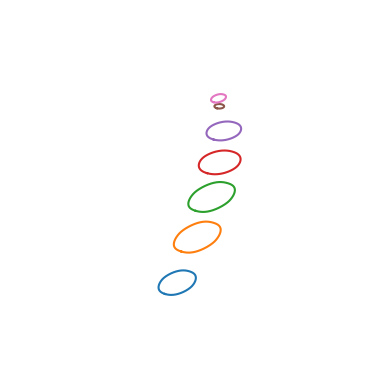

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(r)):
    ax.plot(R[i, :, 0], R[i, :, 1], Z[i]*np.ones(r.shape[1]+1, dtype=np.float32))

plt.axis('equal')
plt.axis('off')
plt.show()

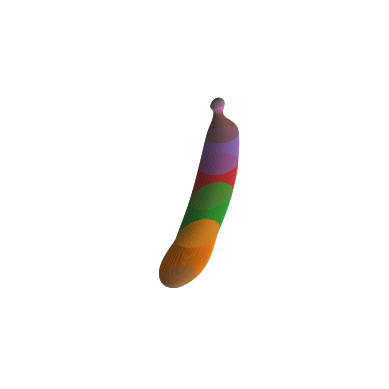

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(FR.shape[0]):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :])

plt.axis('equal')
plt.axis('off')
plt.show()

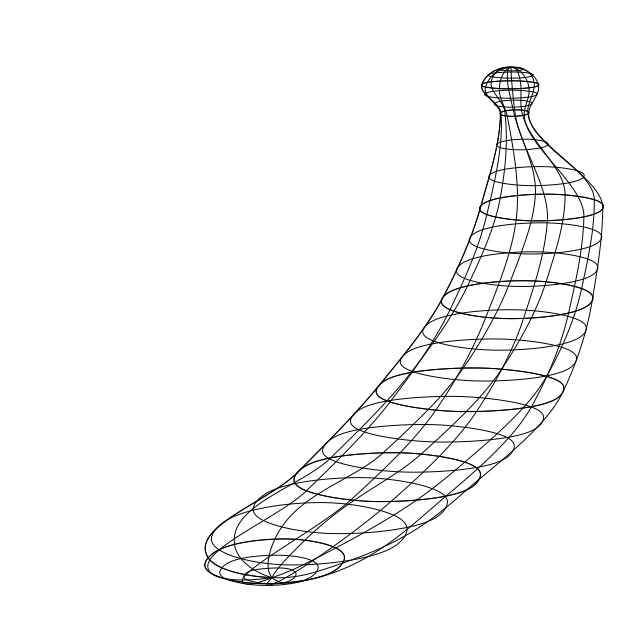

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


for i in range(FR.shape[0]):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 3.5)
ax.set_zlim(-1.5, 1.5)
# plt.axis('equal')
ax.view_init(elev=10, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana.png", dpi=300, transparent=True)
plt.show()

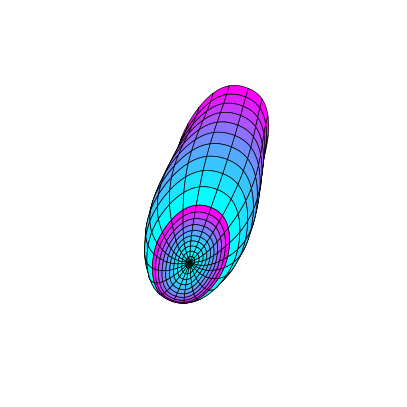

In [12]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,2):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=-70, azim=70) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana_base.png", dpi=300, transparent=True)
plt.show()

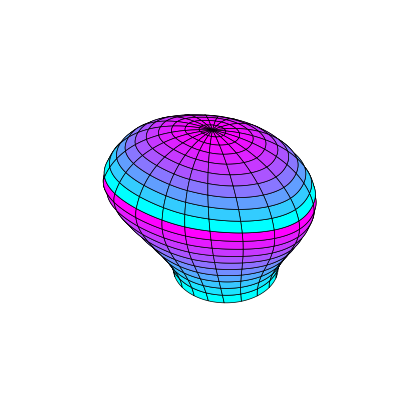

In [13]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(6,8):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=40, azim=20) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana_crown.png", dpi=300, transparent=True)
plt.show()

## Apple Case: CPU base the next cell and GPU based the following cell. Then the subsequent three cells to visualize Apple surface!

In [ ]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'apple'
dt = np.float64

if dt == np.float32:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f32(I[k], seg_pts[k]))
    r = np.stack(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
    FR, Fz = surf_pts_numba_f32(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)
else:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f64(I[k], seg_pts[k]))
    r = np.stack(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
    FR, Fz = surf_pts_numba_f64(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)


In [17]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'apple'
dt = np.float64

if dt == np.float32:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f32(I[k], seg_pts[k]))
    r = np.array(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
else:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f64(I[k], seg_pts[k]))
    r = np.array(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)

    
    
R_gpu   = cuda.to_device(R)
Z_gpu   = cuda.to_device(Z)
RB_gpu  = cuda.to_device(B_Point)
RC_gpu  = cuda.to_device(C_Point)
gRB_gpu = cuda.to_device(gRB)
gRC_gpu = cuda.to_device(gRC)
fb_gpu  = cuda.to_device(fb)
fc_gpu  = cuda.to_device(fc)
gR_gpu  = cuda.to_device(gR)
gz_gpu  = cuda.to_device(gz)

# Hermite coefficients (reused in all kernels)
u = np.linspace(0, 1, n2 + 1, dtype=np.float32)
L0 = 1 - 3 * u**2 + 2 * u**3
L1 = 3 * u**2 - 2 * u**3
H0 = u - 2 * u**2 + u**3
H1 = -u**2 + u**3
u_gpu  = cuda.to_device(u)
L0_gpu = cuda.to_device(L0)
L1_gpu = cuda.to_device(L1)
H0_gpu = cuda.to_device(H0)
H1_gpu = cuda.to_device(H1)

# Output arrays on GPU
FR_gpu = cuda.device_array((N + 1, tot_pts + 1, n2 + 1, 2), dtype=np.float32)
Fz_gpu = cuda.device_array((N + 1, tot_pts + 1, n2 + 1), dtype=np.float32)


# === 3. Define GPU grid/block configuration ===
threadsperblock = (4, 8, 8)
blockspergrid_x = math.ceil((N + 1) / threadsperblock[0])
blockspergrid_y = math.ceil((tot_pts + 1) / threadsperblock[1])
blockspergrid_z = math.ceil((n2 + 1) / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

# === 4. Run the CUDA kernel ===

surf_pts_gpu[blockspergrid, threadsperblock](
    R_gpu, Z_gpu, RB_gpu, RC_gpu,
    B, T, gRB_gpu, gRC_gpu, fb_gpu, fc_gpu,
    gR_gpu, gz_gpu,
    ord(bt), ord(ct),  # base_circular, crown_circular
    FR_gpu, Fz_gpu,
    u_gpu, L0_gpu, L1_gpu, H0_gpu, H1_gpu
)

cuda.synchronize()

# === 5. Copy final results back to CPU ===
FR = FR_gpu.copy_to_host()
Fz = Fz_gpu.copy_to_host()


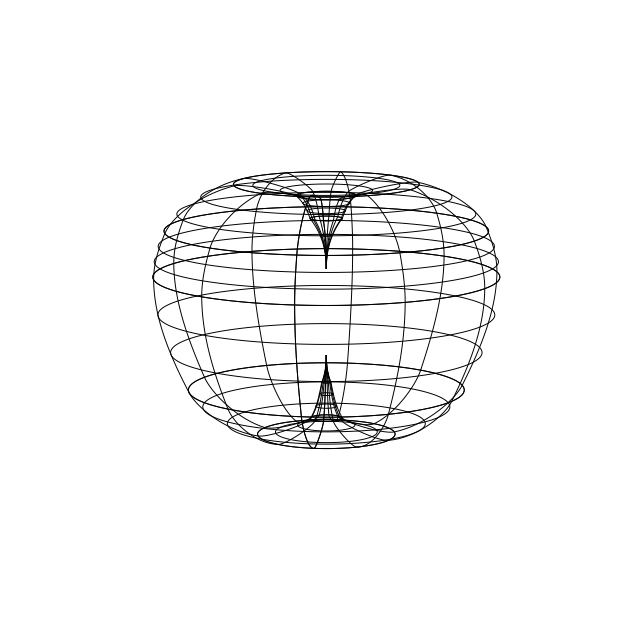

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


for i in range(FR.shape[0]):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')

plt.axis('equal')
ax.view_init(elev=10, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple.png", dpi=300, transparent=True)
plt.show()

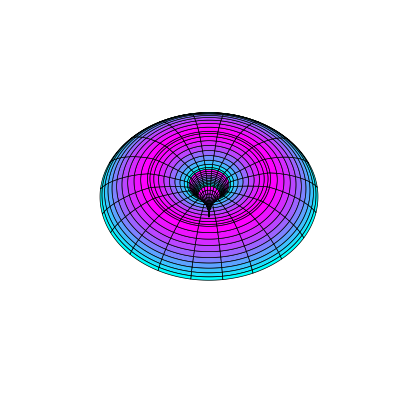

In [19]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(6,10):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')
plt.axis('equal')
ax.view_init(elev=-50, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple_crown.png", dpi=300, transparent=True)
plt.show()

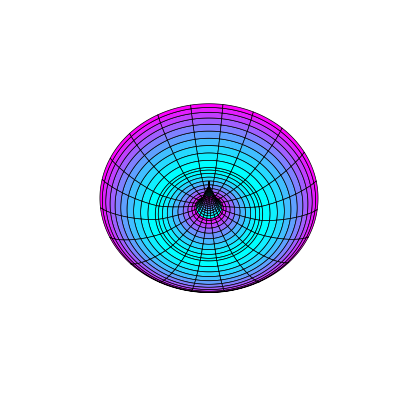

In [20]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,4):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=60, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple_base.png", dpi=300, transparent=True)
plt.show()

## Vase Case: CPU base the next cell and GPU based the following cell. Then the subsequent three cells to visualize Vase surface!

In [ ]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'vase'
dt = np.float64

if dt == np.float32:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f32(I[k], seg_pts[k]))
    r = np.stack(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
    FR, Fz = surf_pts_numba_f32(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)
else:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f64(I[k], seg_pts[k]))
    r = np.stack(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
    FR, Fz = surf_pts_numba_f64(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)


In [15]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'vase'
dt = np.float64

if dt == np.float32:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f32(I[k], seg_pts[k]))
    r = np.array(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f32(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f32(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
else:
    I, Z, Null_Hts = data_3d_shape(ds = ds)

    tot_pts, seg_pts = t_no_pts(I, n1)
    
    N = len(seg_pts)
    M = 4
    step = tot_pts // M
    
    r = []
    for k in range(len(I)):
        r.append(curve_goodman_numba_f64(I[k], seg_pts[k]))
    r = np.array(r)
    
    R = match_parameters(r, N, tot_pts)
    B_Point, C_Point = base_crown_pt_numba_float(R, N, tot_pts, M, step)
    
    if ds == 'apple':
        B = Null_Hts[0]
        T = Null_Hts[1]
        bt = ct = 'n'
    else:
        B, T = base_crown_ht_numba_f64(R, N, tot_pts, M, step, Z, Null_Hts)
        bt = ct = 'y'
    
    gR, gz, gRB, gRC, fb, fc = surf_tangent_numba_f64(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)

    
    
R_gpu   = cuda.to_device(R)
Z_gpu   = cuda.to_device(Z)
RB_gpu  = cuda.to_device(B_Point)
RC_gpu  = cuda.to_device(C_Point)
gRB_gpu = cuda.to_device(gRB)
gRC_gpu = cuda.to_device(gRC)
fb_gpu  = cuda.to_device(fb)
fc_gpu  = cuda.to_device(fc)
gR_gpu  = cuda.to_device(gR)
gz_gpu  = cuda.to_device(gz)

# Hermite coefficients (reused in all kernels)
u = np.linspace(0, 1, n2 + 1, dtype=np.float32)
L0 = 1 - 3 * u**2 + 2 * u**3
L1 = 3 * u**2 - 2 * u**3
H0 = u - 2 * u**2 + u**3
H1 = -u**2 + u**3
u_gpu  = cuda.to_device(u)
L0_gpu = cuda.to_device(L0)
L1_gpu = cuda.to_device(L1)
H0_gpu = cuda.to_device(H0)
H1_gpu = cuda.to_device(H1)

# Output arrays on GPU
FR_gpu = cuda.device_array((N + 1, tot_pts + 1, n2 + 1, 2), dtype=np.float32)
Fz_gpu = cuda.device_array((N + 1, tot_pts + 1, n2 + 1), dtype=np.float32)


# === 3. Define GPU grid/block configuration ===
threadsperblock = (4, 8, 8)
blockspergrid_x = math.ceil((N + 1) / threadsperblock[0])
blockspergrid_y = math.ceil((tot_pts + 1) / threadsperblock[1])
blockspergrid_z = math.ceil((n2 + 1) / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

# === 4. Run the CUDA kernel ===

surf_pts_gpu[blockspergrid, threadsperblock](
    R_gpu, Z_gpu, RB_gpu, RC_gpu,
    B, T, gRB_gpu, gRC_gpu, fb_gpu, fc_gpu,
    gR_gpu, gz_gpu,
    ord(bt), ord(ct),  # base_circular, crown_circular
    FR_gpu, Fz_gpu,
    u_gpu, L0_gpu, L1_gpu, H0_gpu, H1_gpu
)

cuda.synchronize()

# === 5. Copy final results back to CPU ===
FR = FR_gpu.copy_to_host()
Fz = Fz_gpu.copy_to_host()


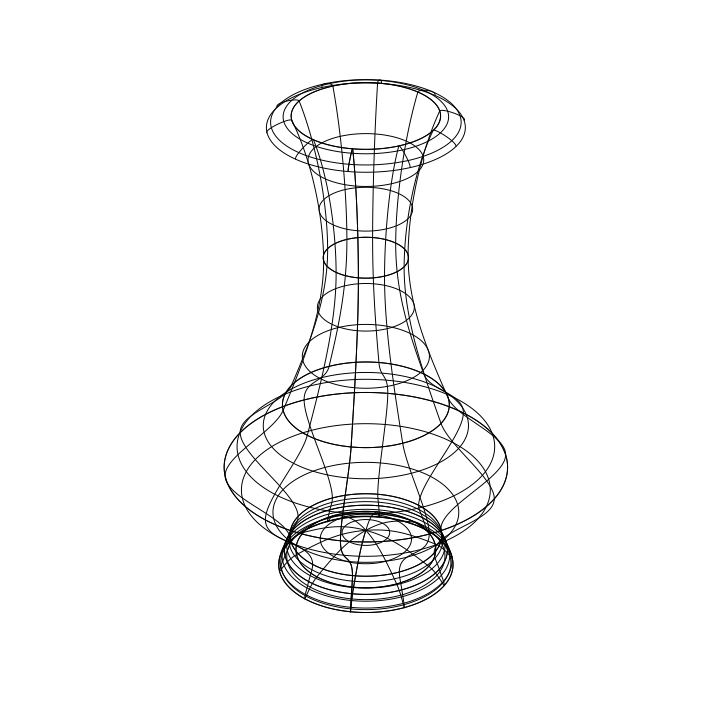

In [16]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')


for i in range(0, FR.shape[0]-1):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')

plt.axis('square')
ax.view_init(elev=30, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("vase.png", dpi=300, transparent=True)
plt.show()

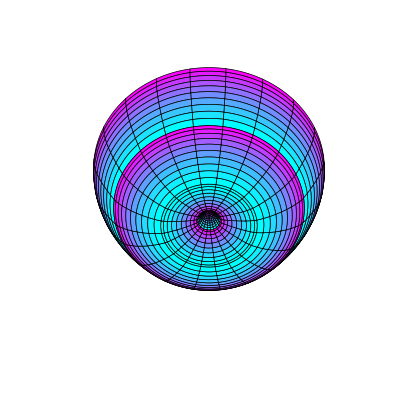

In [21]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,5):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('square')
ax.view_init(elev=-60, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("vase_base.png", dpi=300, transparent=True)
plt.show()